In [ ]:

import warnings
warnings.filterwarnings('ignore')


from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap


spark = SparkSession.builder \
    .appName("PySpark ML Pipeline") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Set the resolution of the plotted figures
plt.rcParams['figure.dpi'] = 200

# Configure Seaborn plot styles: Set background color and use dark grid
sns.set(rc={'axes.facecolor': '#faded9'}, style='darkgrid')

# Placeholder: In PySpark, we would handle datasets using Spark DataFrames and MLlib pipelines instead of pandas/sklearn.
import warnings
warnings.filterwarnings('ignore')




In [ ]:
# Load dataset into a PySpark DataFrame
df = spark.read.csv('/content/heart.csv', header=True, inferSchema=True)

# Show the first few rows of the dataset
df.show()


+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|
| 57|  1|  0|     140| 192|  0|      1|    148|    0|    0.4|    1|  0|   1|     1|
| 56|  0|  1|     140| 294|  0|      0|    153|    0|    1.3|    1|  0|   2|     1|
| 44|  1|  1|     120| 263|  0|      1|    173|    0|    0.0|    2|  0|   3|     1|
| 52|  1|  2|     172| 199|  1|      1|    162|    0|    0.5|    2|  0|   3|

In [ ]:
# Display the schema of the DataFrame
df.printSchema()
# Count the number of rows
print(f"Number of rows: {df.count()}")

# Display a summary of the DataFrame
df.describe().show()


root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)

Number of rows: 303
+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|                sex|                cp|          trestbps|              chol|                fbs|          restecg|           thalach|       

In [ ]:
from pyspark.sql.types import StringType

# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Identify the features to be converted to StringType
features_to_convert = [col for col in df.columns if col not in continuous_features]

# Convert the identified features to StringType
for feature in features_to_convert:
    df = df.withColumn(feature, df[feature].cast(StringType()))

# Show the updated schema to verify data types
df.printSchema()
# Read dataset
df = pd.read_csv('/content/heart.csv')
df


root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: string (nullable = true)
 |-- restecg: string (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: string (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: string (nullable = true)
 |-- ca: string (nullable = true)
 |-- thal: string (nullable = true)
 |-- target: string (nullable = true)



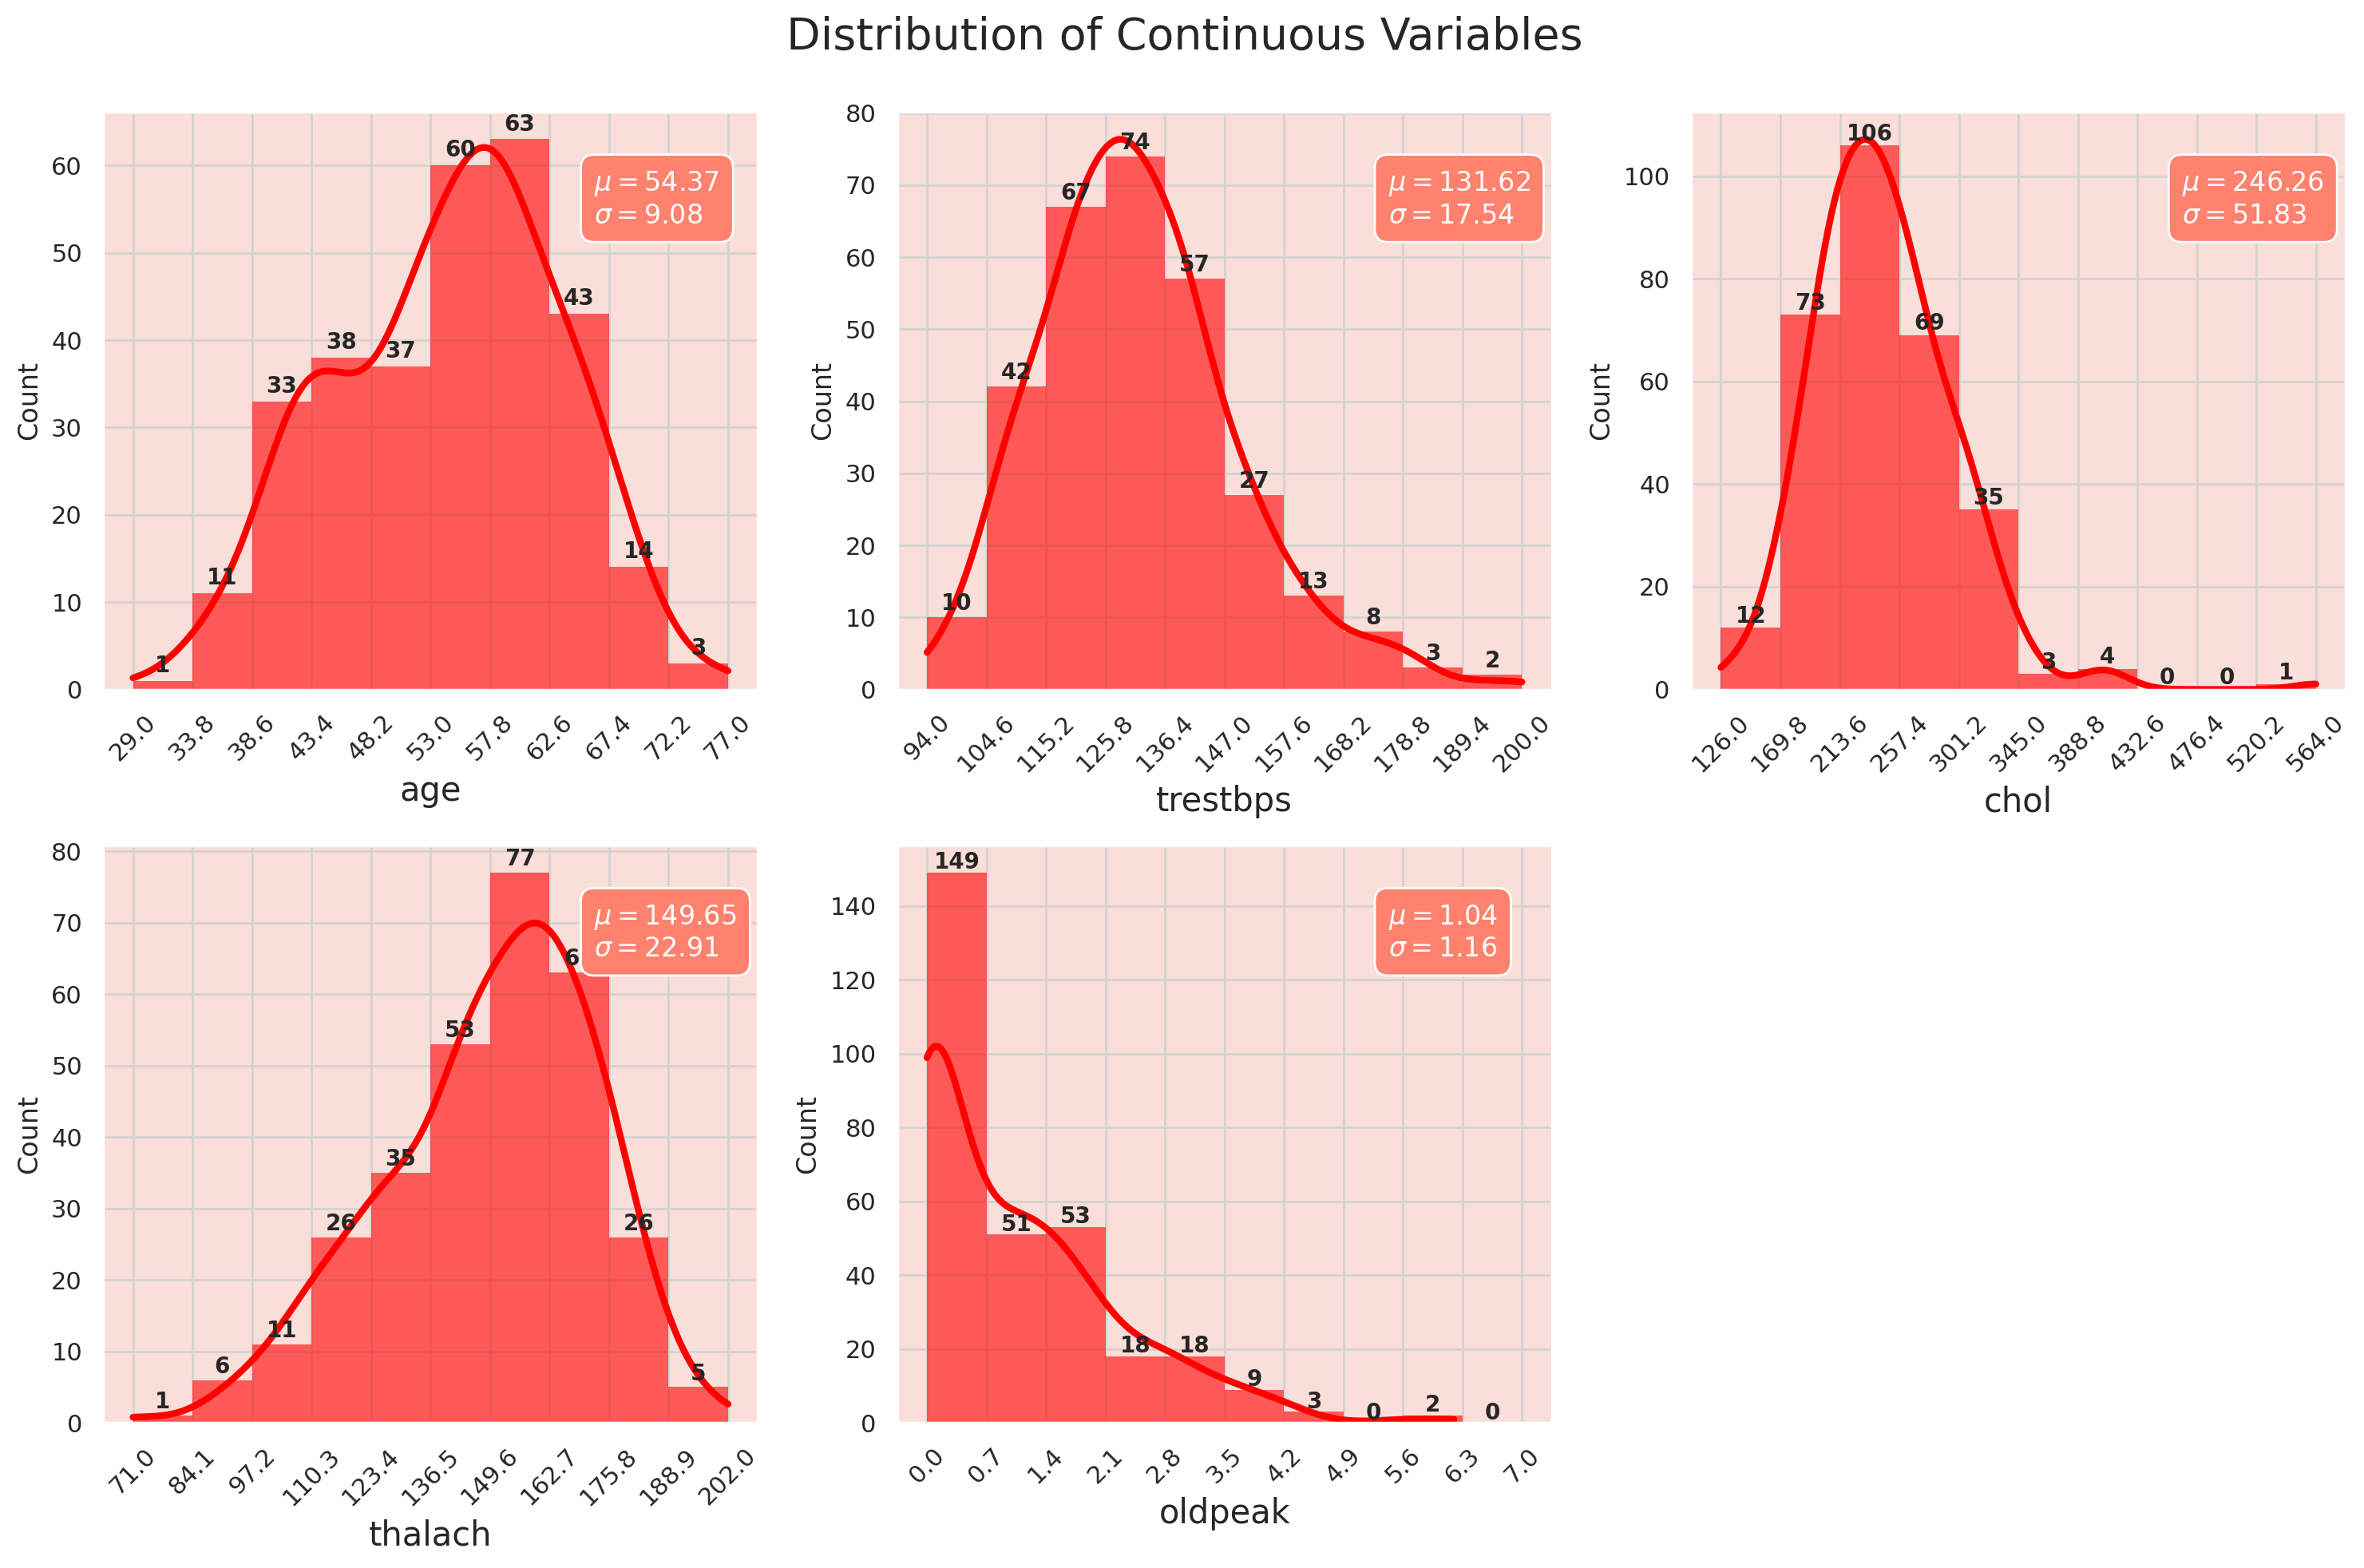

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out continuous features for univariate analysis
df_continuous = df.select(continuous_features)

# Convert to Pandas DataFrame for plotting
df_continuous_pd = df_continuous.toPandas()

# Set up the subplot
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Loop to plot histograms for each continuous feature
for i, col in enumerate(continuous_features):
    x = i // 3
    y = i % 3
    values, bin_edges = np.histogram(
        df_continuous_pd[col],
        range=(np.floor(df_continuous_pd[col].min()), np.ceil(df_continuous_pd[col].max()))
    )

    graph = sns.histplot(data=df_continuous_pd, x=col, bins=bin_edges, kde=True, ax=ax[x, y],
                         edgecolor='none', color='red', alpha=0.6, line_kws={'lw': 3})
    ax[x, y].set_xlabel(col, fontsize=15)
    ax[x, y].set_ylabel('Count', fontsize=12)
    ax[x, y].set_xticks(np.round(bin_edges, 1))
    ax[x, y].set_xticklabels(ax[x, y].get_xticks(), rotation=45)
    ax[x, y].grid(color='lightgrey')

    for j, p in enumerate(graph.patches):
        ax[x, y].annotate('{}'.format(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height() + 1),
                          ha='center', fontsize=10, fontweight="bold")

    textstr = '\n'.join((
        r'$\mu=%.2f$' % df_continuous_pd[col].mean(),
        r'$\sigma=%.2f$' % df_continuous_pd[col].std()
    ))
    ax[x, y].text(0.75, 0.9, textstr, transform=ax[x, y].transAxes, fontsize=12, verticalalignment='top',
                  color='white', bbox=dict(boxstyle='round', facecolor='#ff826e', edgecolor='white', pad=0.5))

# Adjust the layout
if len(continuous_features) < 6:
    for idx in range(len(continuous_features), 6):
        ax[idx // 3, idx % 3].axis('off')

plt.suptitle('Distribution of Continuous Variables', fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


In [ ]:
from pyspark.sql.types import StringType

# Identify categorical features
categorical_features = [col_name for col_name, dtype in df.dtypes if dtype == 'string']

# Filter out the categorical features
df_categorical = df.select(categorical_features)

# Show the first few rows of the categorical DataFrame
df_categorical.show()


+---+---+---+-------+-----+-----+---+----+------+
|sex| cp|fbs|restecg|exang|slope| ca|thal|target|
+---+---+---+-------+-----+-----+---+----+------+
|  1|  3|  1|      0|    0|    0|  0|   1|     1|
|  1|  2|  0|      1|    0|    0|  0|   2|     1|
|  0|  1|  0|      0|    0|    2|  0|   2|     1|
|  1|  1|  0|      1|    0|    2|  0|   2|     1|
|  0|  0|  0|      1|    1|    2|  0|   2|     1|
|  1|  0|  0|      1|    0|    1|  0|   1|     1|
|  0|  1|  0|      0|    0|    1|  0|   2|     1|
|  1|  1|  0|      1|    0|    2|  0|   3|     1|
|  1|  2|  1|      1|    0|    2|  0|   3|     1|
|  1|  2|  0|      1|    0|    2|  0|   2|     1|
|  1|  0|  0|      1|    0|    2|  0|   2|     1|
|  0|  2|  0|      1|    0|    2|  0|   2|     1|
|  1|  1|  0|      1|    0|    2|  0|   2|     1|
|  1|  3|  0|      0|    1|    1|  0|   2|     1|
|  0|  3|  1|      0|    0|    2|  0|   2|     1|
|  0|  2|  0|      1|    0|    1|  0|   2|     1|
|  0|  2|  0|      1|    0|    2|  0|   2|     1|


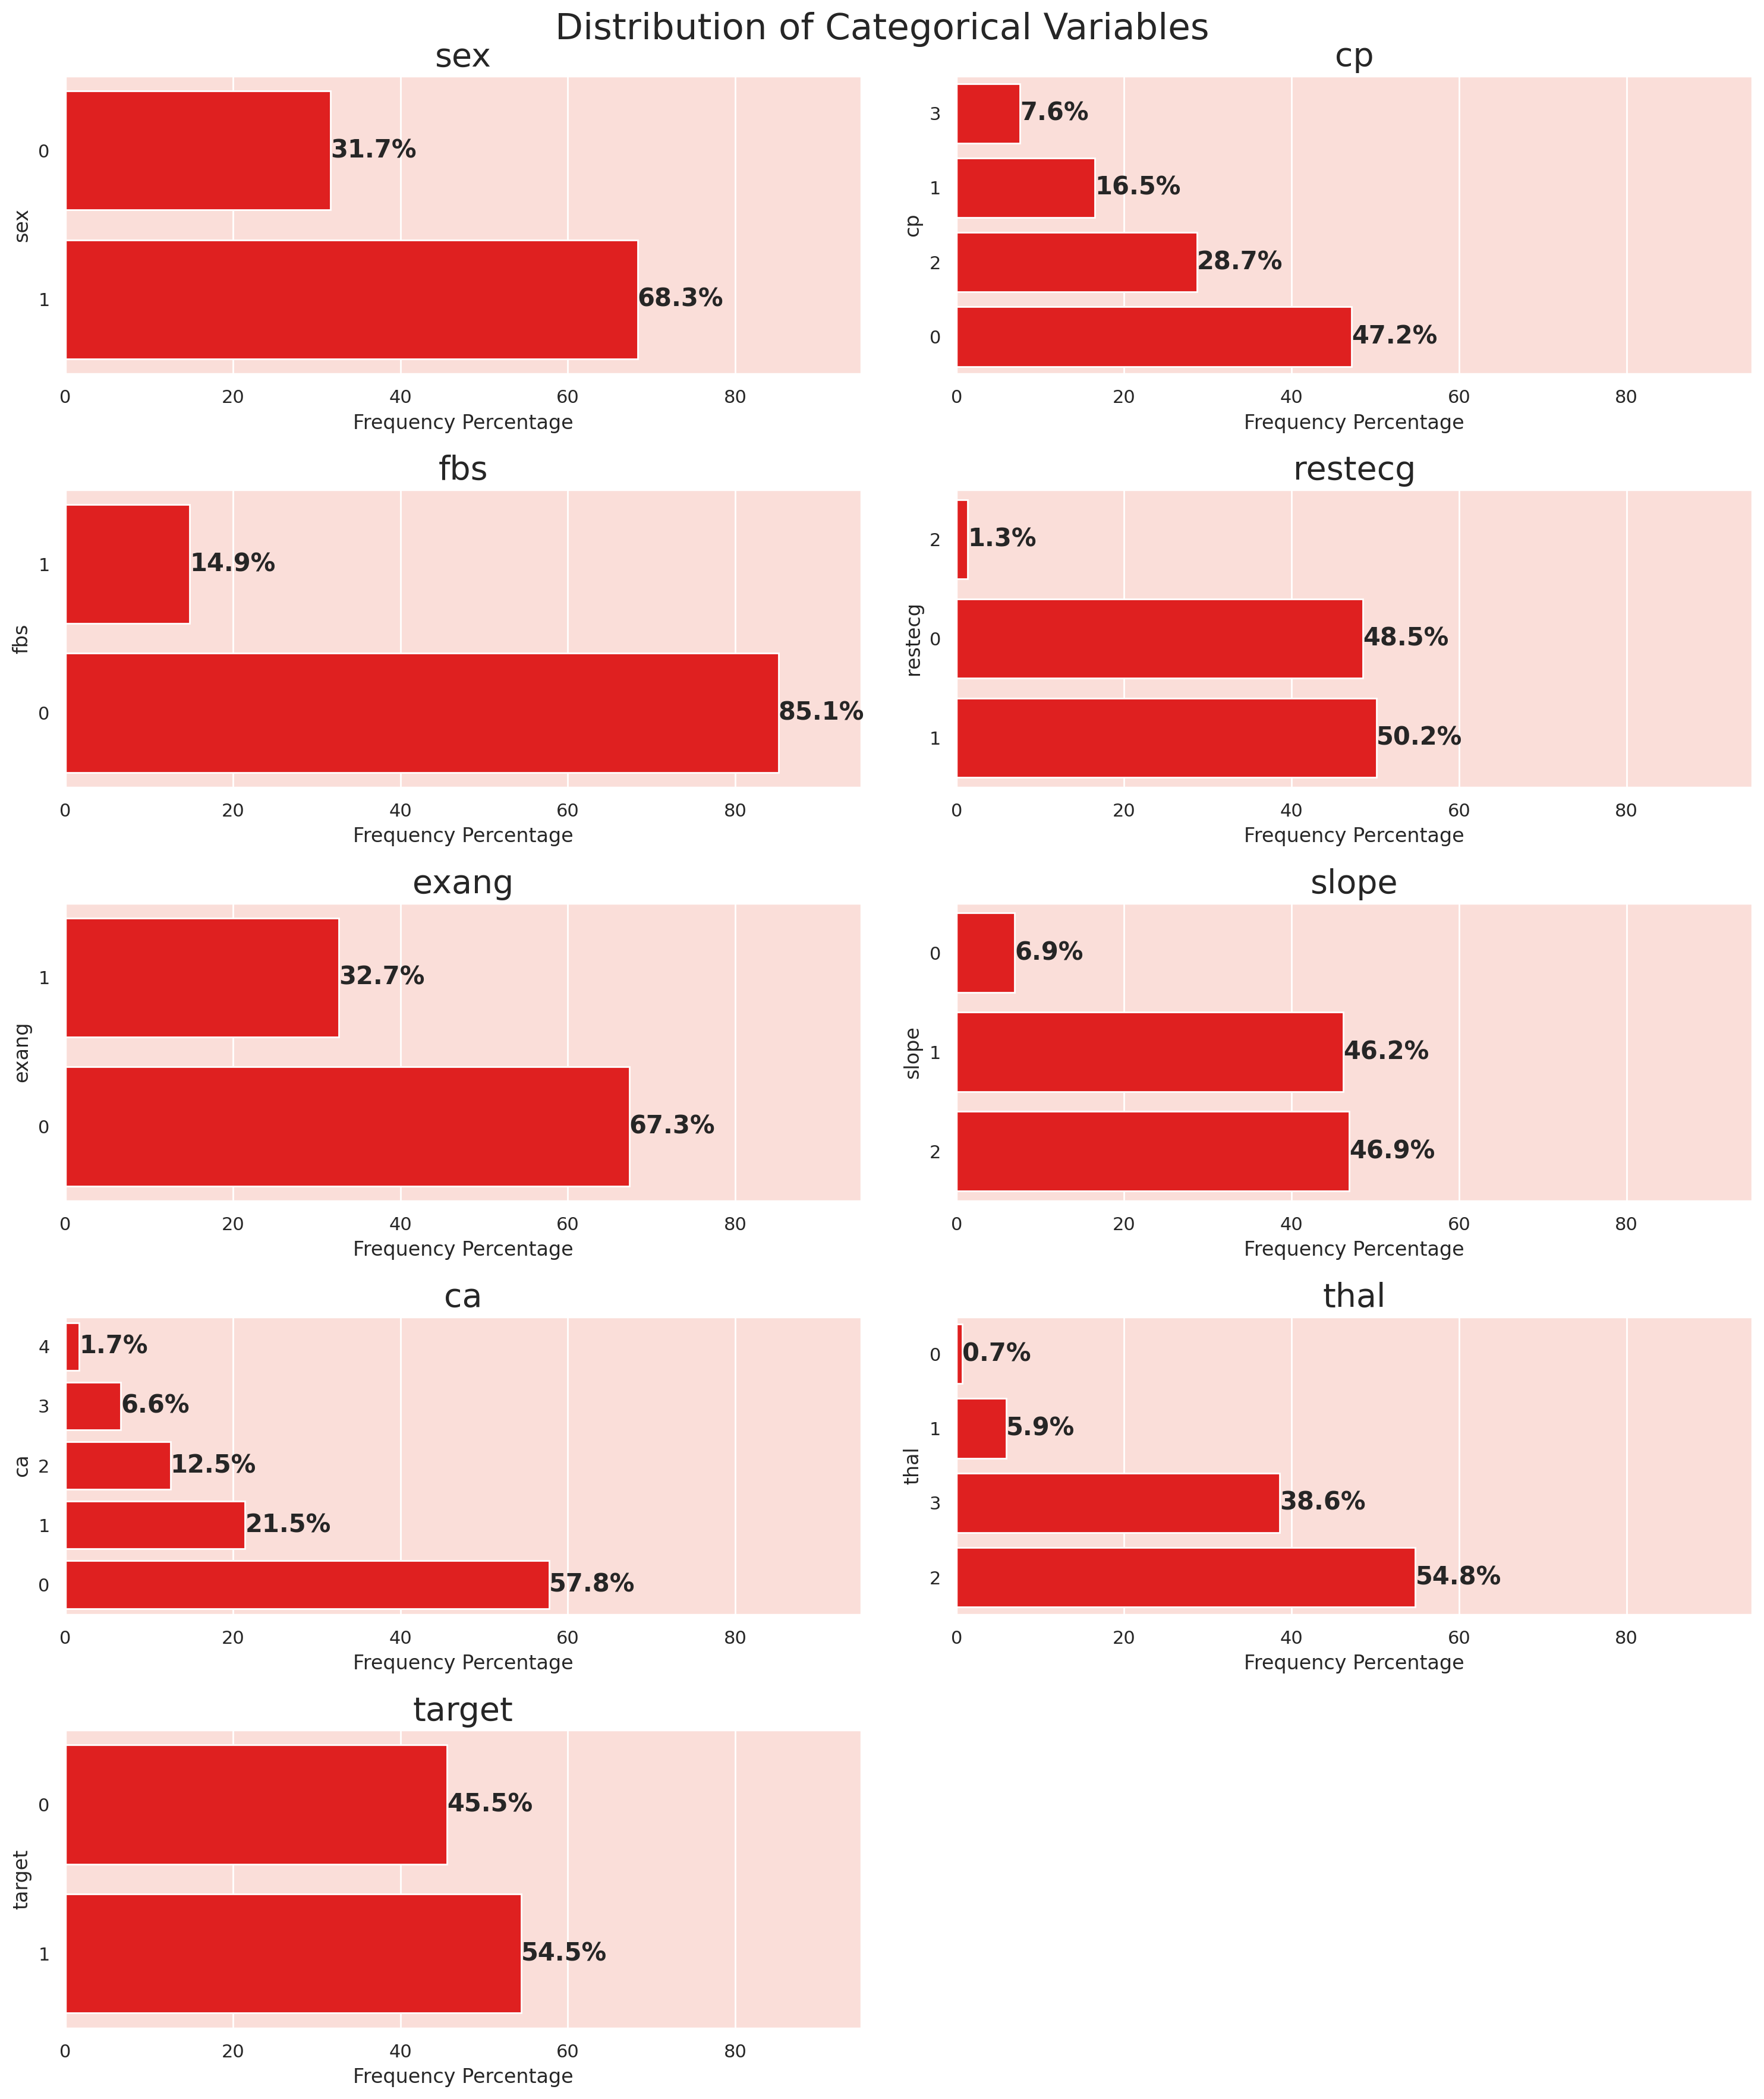

In [ ]:
from pyspark.sql.functions import col

# Set up the subplot for a 5x2 layout (to handle more than 8 categorical features if needed)
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15, 18))

# Loop to plot bar charts for each categorical feature in the 5x2 layout
for i, column in enumerate(categorical_features):  # Use a different variable name 'column' to avoid conflict
    row = i // 2
    col_idx = i % 2

    # Calculate frequency counts for categorical columns
    value_counts = df.groupBy(column).count().withColumn("percentage", (col("count") / df.count()) * 100)

    # Convert the result to pandas for plotting
    value_counts_pd = value_counts.toPandas().sort_values("percentage")

    # Plot bar chart
    sns.barplot(x='percentage', y=column, data=value_counts_pd, ax=ax[row, col_idx], color='red')

    # Add frequency percentages to the bars
    for index, value in enumerate(value_counts_pd['percentage']):
        ax[row, col_idx].text(value, index, str(round(value, 1)) + '%', fontsize=15, weight='bold', va='center')

    ax[row, col_idx].set_xlim([0, 95])
    ax[row, col_idx].set_xlabel('Frequency Percentage', fontsize=12)
    ax[row, col_idx].set_title(f'{column}', fontsize=20)

# Hide the last subplot if there are fewer categorical features
if len(categorical_features) < 10:
    ax[4, 1].axis('off')

plt.suptitle('Distribution of Categorical Variables', fontsize=22)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


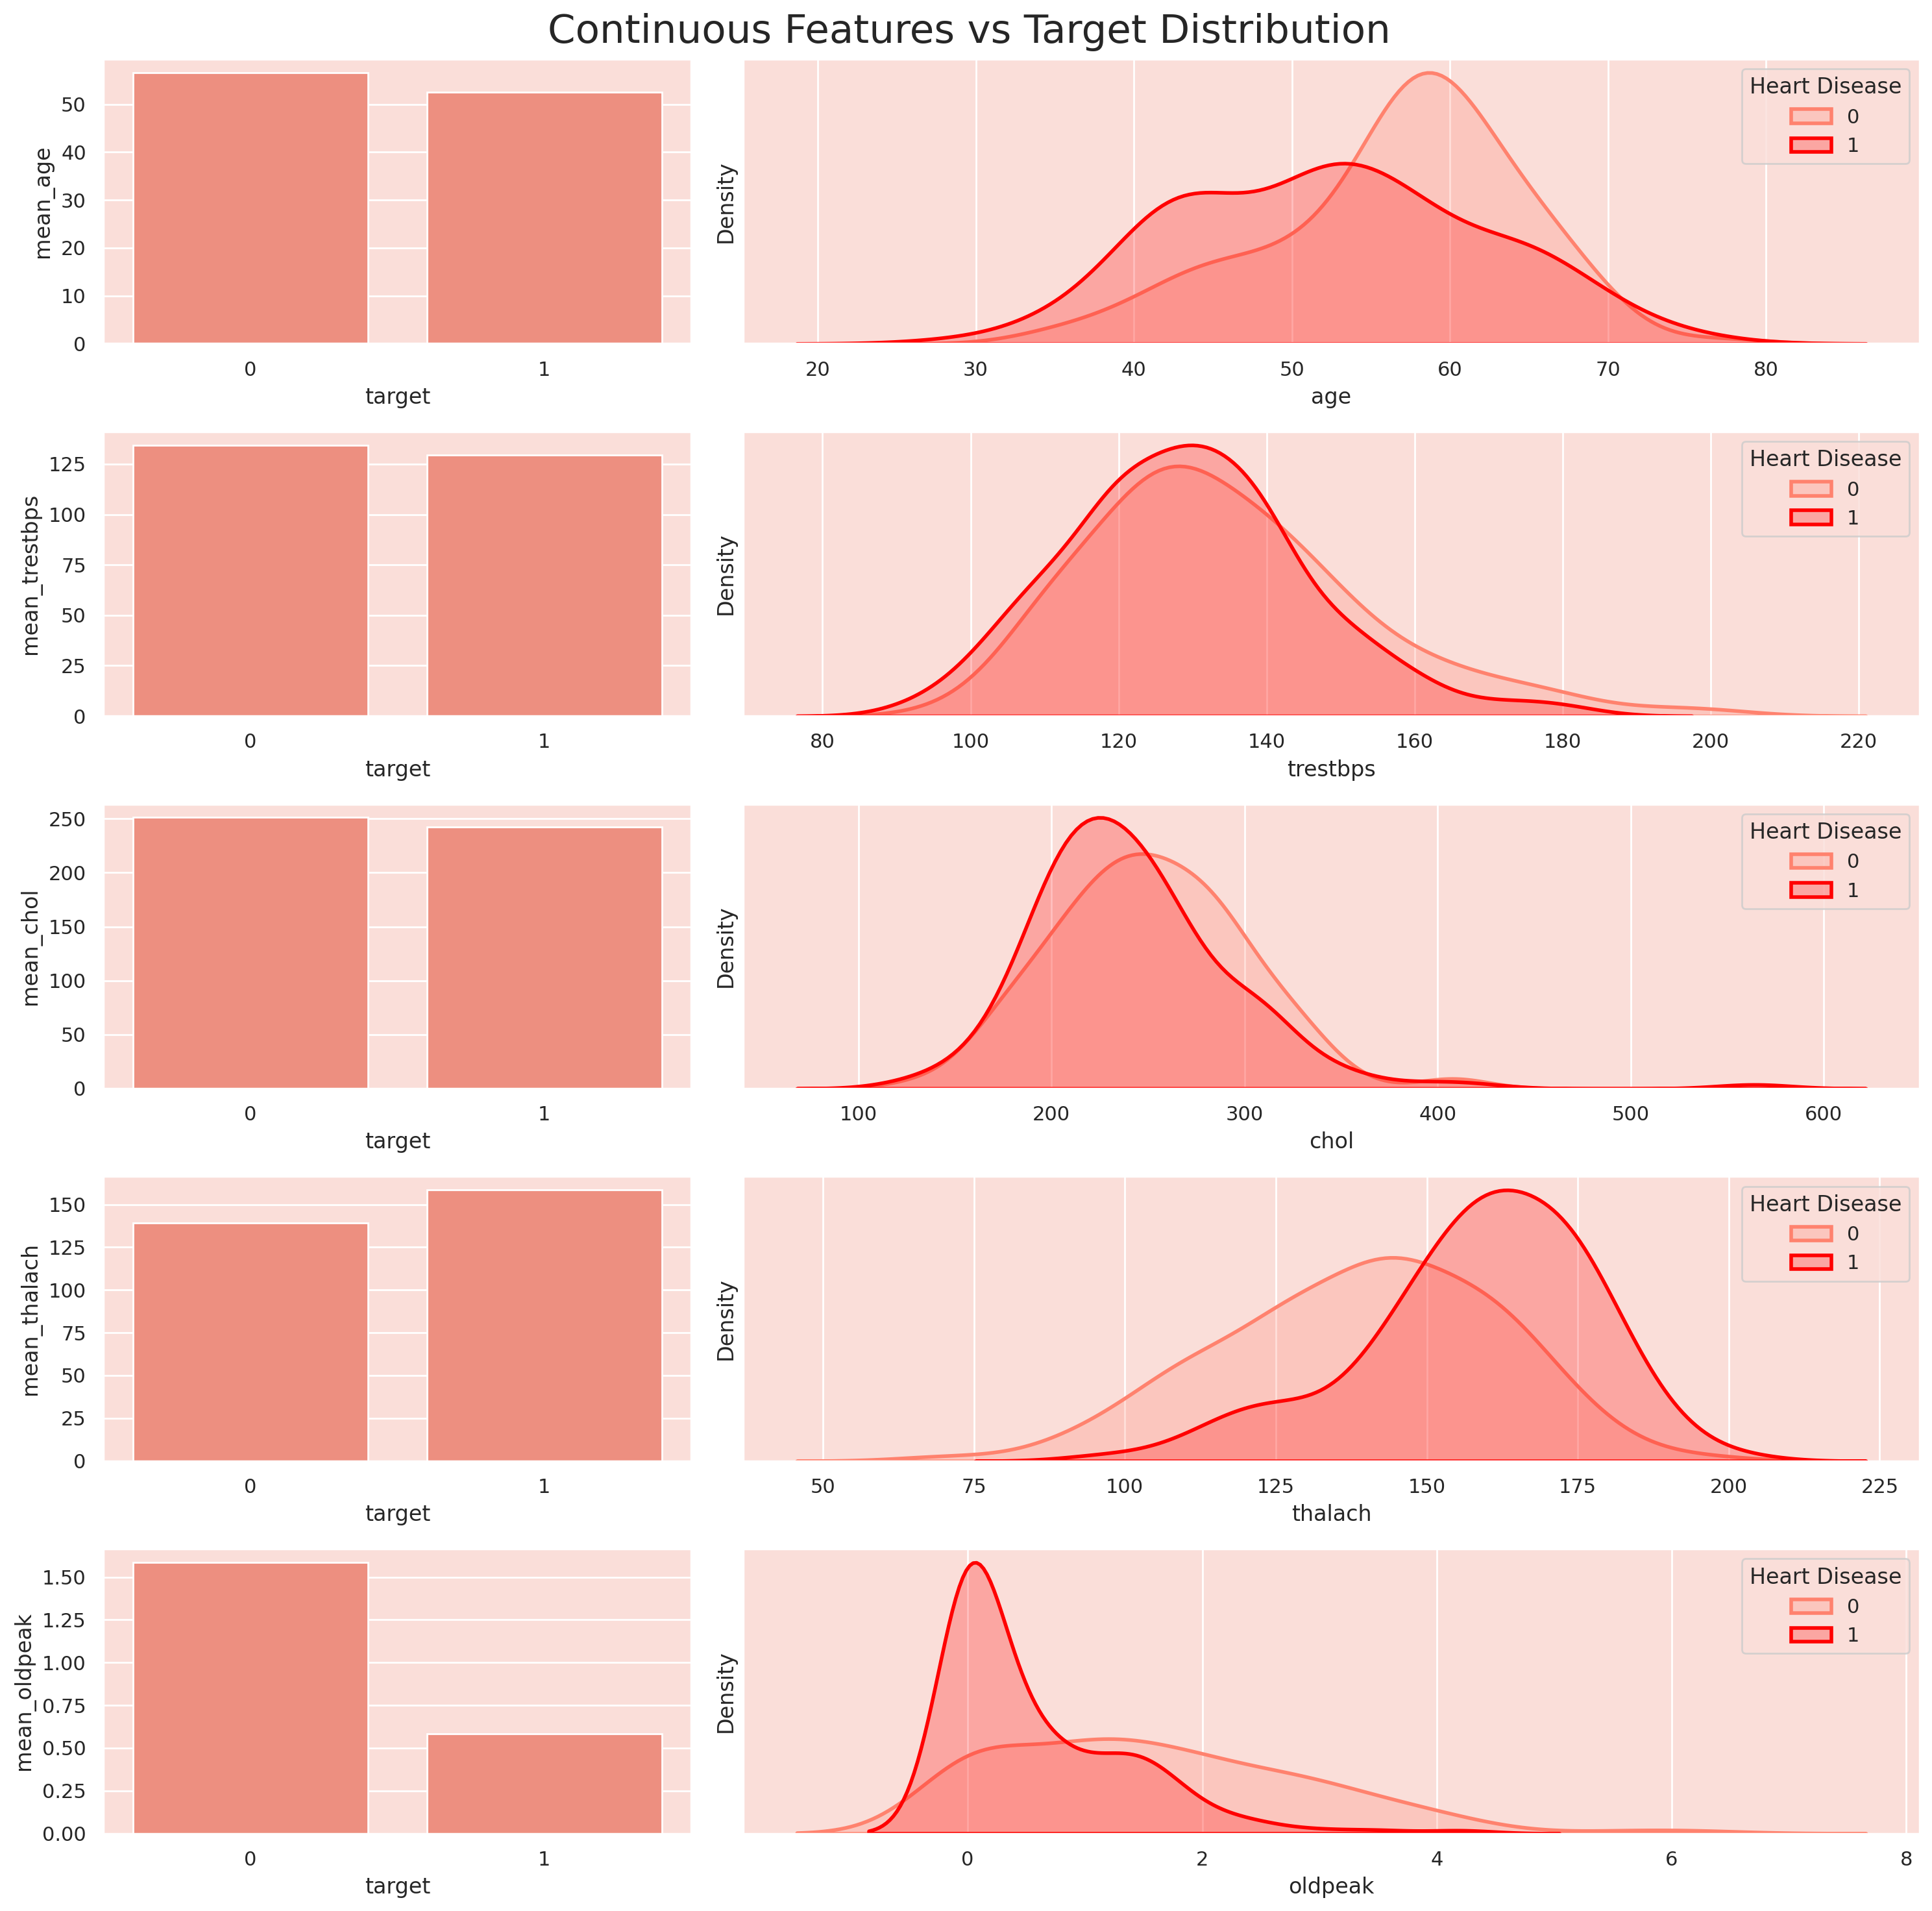

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, mean

# Set color palette
sns.set_palette(['#ff826e', 'red'])

# Create the subplots
fig, ax = plt.subplots(len(continuous_features), 2, figsize=(15,15), gridspec_kw={'width_ratios': [1, 2]})

# Loop through each continuous feature to create barplots and kde plots
for i, col_name in enumerate(continuous_features):
    # Barplot showing the mean value of the feature for each target category
    mean_values = df.groupBy("target").agg(mean(col_name).alias(f"mean_{col_name}")).toPandas()
    sns.barplot(x="target", y=f"mean_{col_name}", data=mean_values, ax=ax[i, 0])

    # KDE plot showing the distribution of the feature for each target category
    # Get the data for target = 0
    df_target_0 = df.filter(df["target"] == 0).select(col_name).toPandas()
    # Get the data for target = 1
    df_target_1 = df.filter(df["target"] == 1).select(col_name).toPandas()

    sns.kdeplot(df_target_0[col_name], fill=True, linewidth=2, ax=ax[i, 1], label='0')
    sns.kdeplot(df_target_1[col_name], fill=True, linewidth=2, ax=ax[i, 1], label='1')

    ax[i, 1].set_yticks([])
    ax[i, 1].legend(title='Heart Disease', loc='upper right')

# Set the title for the entire figure
plt.suptitle('Continuous Features vs Target Distribution', fontsize=22)
plt.tight_layout()
plt.show()


In [ ]:
# Remove 'target' from the categorical_features list
categorical_features = [feature for feature in categorical_features if feature != 'target']

# Show the updated list
print(categorical_features)


['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']


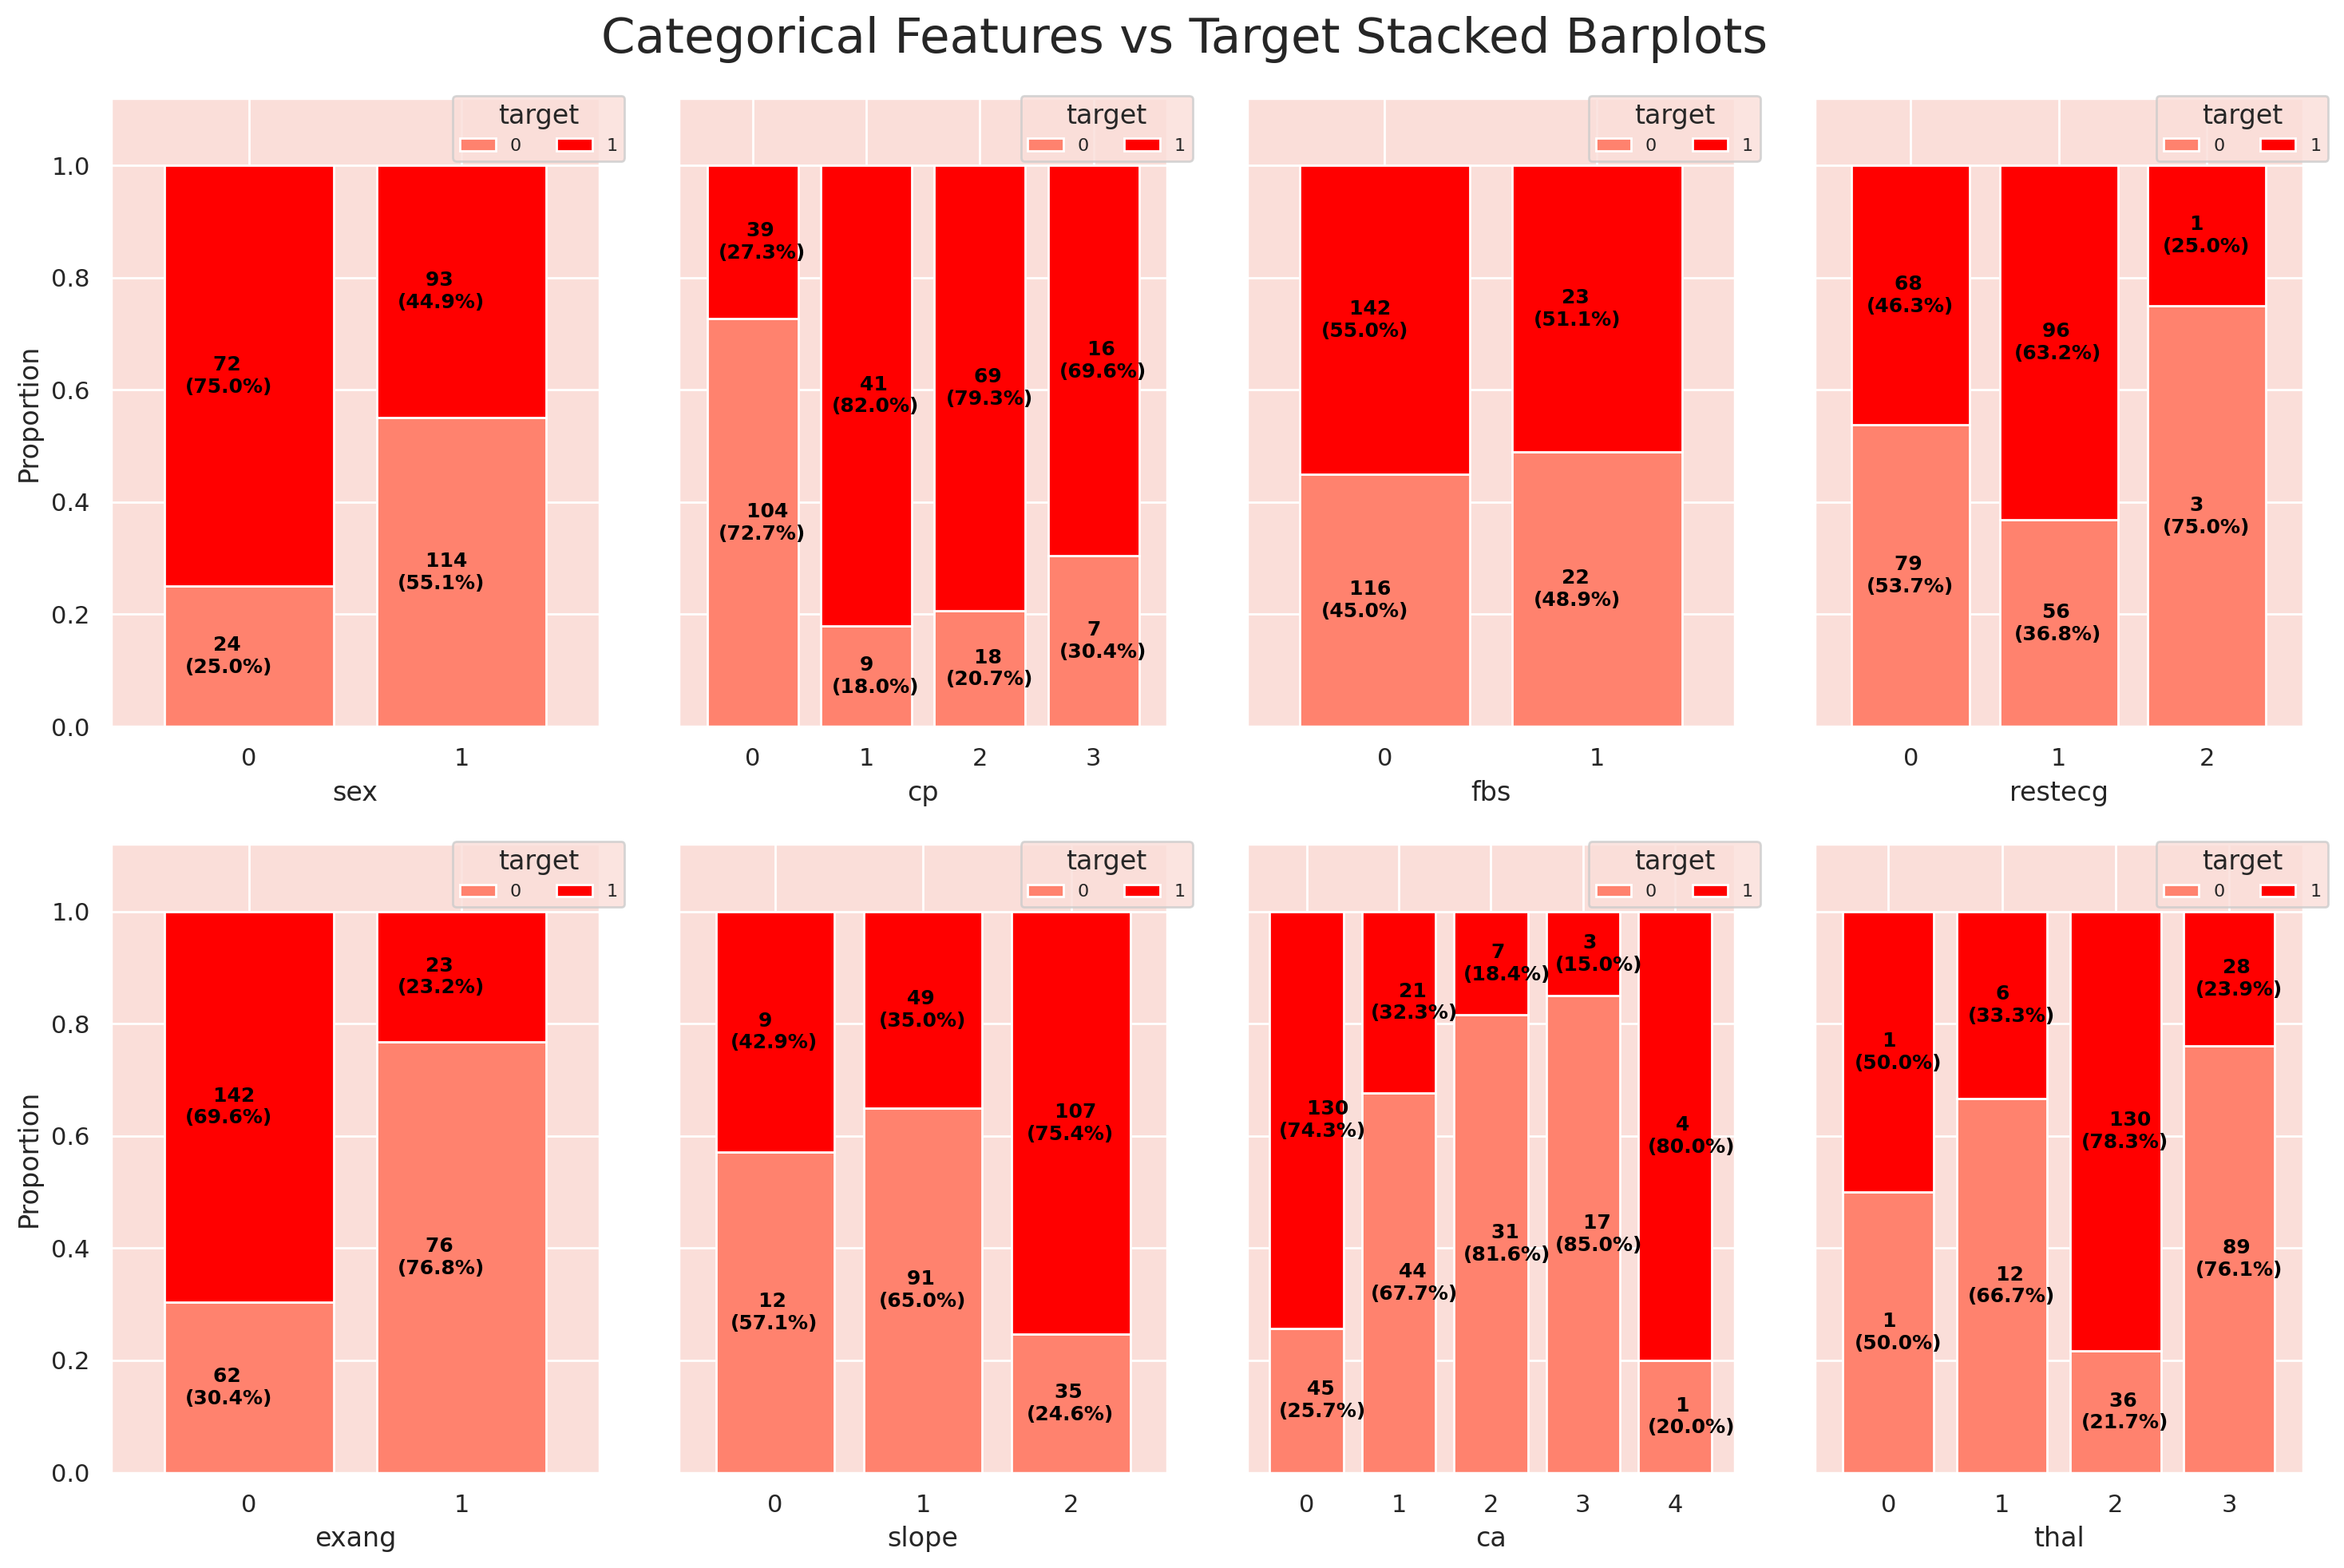

In [ ]:
from pyspark.sql import functions as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,10))

for i, col in enumerate(categorical_features):
    df_col_target = df.select(col, 'target').toPandas()

    cross_tab = pd.crosstab(index=df_col_target[col], columns=df_col_target['target'])
    cross_tab_prop = pd.crosstab(index=df_col_target[col], columns=df_col_target['target'], normalize='index')

    cmp = ListedColormap(['#ff826e', 'red'])

    x, y = i // 4, i % 4
    cross_tab_prop.plot(kind='bar', ax=ax[x, y], stacked=True, width=0.8, colormap=cmp,
                        legend=False, ylabel='Proportion', sharey=True)

    for idx, val in enumerate([*cross_tab.index.values]):
        for (proportion, count, y_location) in zip(cross_tab_prop.loc[val], cross_tab.loc[val], cross_tab_prop.loc[val].cumsum()):
            ax[x, y].text(x=idx - 0.3, y=(y_location - proportion) + (proportion / 2) - 0.03,
                         s=f'    {count}\n({np.round(proportion * 100, 1)}%)',
                         color="black", fontsize=9, fontweight="bold")

    ax[x, y].legend(title='target', loc=(0.7, 0.9), fontsize=8, ncol=2)
    ax[x, y].set_ylim([0, 1.12])
    ax[x, y].set_xticklabels(ax[x, y].get_xticklabels(), rotation=0)

plt.suptitle('Categorical Features vs Target Stacked Barplots', fontsize=22)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql import functions as F

# Check for missing values in each column
missing_values = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Show the missing values
missing_values.show()


+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+



In [ ]:
continuous_features

['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [ ]:
from pyspark.sql import functions as F

# List of continuous features
continuous_features = ['age', 'trestbps', 'chol']  # Replace with your actual feature names

# Dictionary to store outlier counts
outlier_counts = {}

# Loop through each feature to calculate outliers
for feature in continuous_features:
    # Calculate Q1, Q3, and IQR for the feature
    quantiles = df.approxQuantile(feature, [0.25, 0.75], 0.01)
    Q1, Q3 = quantiles[0], quantiles[1]
    IQR = Q3 - Q1

    # Calculate lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers for the current feature
    outlier_count = df.filter((F.col(feature) < lower_bound) | (F.col(feature) > upper_bound)).count()
    outlier_counts[feature] = outlier_count

# Display the outlier counts
for feature, count in outlier_counts.items():
    print(f"Feature: {feature}, Outlier Count: {count}")


Feature: age, Outlier Count: 0
Feature: trestbps, Outlier Count: 9
Feature: chol, Outlier Count: 5


In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql import functions as F

# List of categorical features for one-hot encoding
categorical_features = ['cp', 'restecg', 'thal']

# Initialize the StringIndexer and OneHotEncoder for each categorical feature
indexers = []
encoders = []

# Create a pipeline for one-hot encoding categorical features
for feature in categorical_features:
    # Index the categorical features
    indexer = StringIndexer(inputCol=feature, outputCol=feature + '_index')
    indexers.append(indexer)

    # Encode the indexed values into one-hot vectors
    encoder = OneHotEncoder(inputCol=feature + '_index', outputCol=feature + '_encoded')
    encoders.append(encoder)

# List of categorical features to convert to integers
features_to_convert = ['sex', 'fbs', 'exang', 'slope', 'ca', 'target']

# Create indexers for the categorical features that need to be converted to integer type
for feature in features_to_convert:
    indexer = StringIndexer(inputCol=feature, outputCol=feature + '_index')
    indexers.append(indexer)

# Combine the indexers and encoders into a pipeline
pipeline = Pipeline(stages=indexers + encoders)

# Apply the pipeline to the DataFrame
df_encoded = pipeline.fit(df).transform(df)

# Select the necessary columns (drop original categorical columns and keep encoded ones)
encoded_columns = [col + '_encoded' for col in categorical_features]
encoded_columns += [col + '_index' for col in features_to_convert]

# Show the transformed DataFrame with one-hot encoded features and integer-encoded columns
df_encoded.select(encoded_columns).show()


+-------------+---------------+-------------+---------+---------+-----------+-----------+--------+------------+
|   cp_encoded|restecg_encoded| thal_encoded|sex_index|fbs_index|exang_index|slope_index|ca_index|target_index|
+-------------+---------------+-------------+---------+---------+-----------+-----------+--------+------------+
|    (3,[],[])|  (2,[1],[1.0])|(3,[2],[1.0])|      0.0|      1.0|        0.0|        2.0|     0.0|         0.0|
|(3,[1],[1.0])|  (2,[0],[1.0])|(3,[0],[1.0])|      0.0|      0.0|        0.0|        2.0|     0.0|         0.0|
|(3,[2],[1.0])|  (2,[1],[1.0])|(3,[0],[1.0])|      1.0|      0.0|        0.0|        0.0|     0.0|         0.0|
|(3,[2],[1.0])|  (2,[0],[1.0])|(3,[0],[1.0])|      0.0|      0.0|        0.0|        0.0|     0.0|         0.0|
|(3,[0],[1.0])|  (2,[0],[1.0])|(3,[0],[1.0])|      1.0|      0.0|        1.0|        0.0|     0.0|         0.0|
|(3,[0],[1.0])|  (2,[0],[1.0])|(3,[2],[1.0])|      0.0|      0.0|        0.0|        1.0|     0.0|      

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

# Assuming df is already defined as your initial DataFrame
spark = SparkSession.builder.appName("example").getOrCreate()

# Example: Encoding and transforming the columns
indexer_cp = StringIndexer(inputCol="cp", outputCol="cp_index")
encoder_cp = OneHotEncoder(inputCol="cp_index", outputCol="cp_encoded")

# Define transformations for other categorical features...
# Apply similar transformations for other features here

# Create a pipeline with the defined transformations
pipeline = Pipeline(stages=[indexer_cp, encoder_cp])

# Fit and transform the DataFrame
df_encoded = pipeline.fit(df).transform(df)

# Now you can try to display the first 5 rows
df_encoded.show(5)


+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------+-------------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|cp_index|   cp_encoded|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------+-------------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|     3.0|    (3,[],[])|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|     1.0|(3,[1],[1.0])|
| 41|  0|  1|     130| 204|  0|      0|    172|    0|    1.4|    2|  0|   2|     1|     2.0|(3,[2],[1.0])|
| 56|  1|  1|     120| 236|  0|      1|    178|    0|    0.8|    2|  0|   2|     1|     2.0|(3,[2],[1.0])|
| 57|  0|  0|     120| 354|  0|      1|    163|    1|    0.6|    2|  0|   2|     1|     0.0|(3,[0],[1.0])|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+--------+-------------+
only showing top 5 rows



In [ ]:
from pyspark.sql import functions as F

# Define the continuous features
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']  # Replace with actual feature names

# Select features (X) and output labels (y)
X = df_encoded.select(continuous_features)  # Select only continuous features
y = df_encoded.select('target')  # Target column

# Split the data into train and test sets (80% train, 20% test)
train_data, test_data = df_encoded.randomSplit([0.8, 0.2], seed=0)

# The train_data and test_data will include both X and y


Transformed data for age: Min: 91.01611049549072, Max: 378.20860695238713, Mean: 229.96667243025036
Transformed data for trestbps: Min: 1.4688867482534984, Max: 1.5008921918285674, Mean: 1.48450889316372
Transformed data for chol: Min: 4.766089255967534, Max: 6.2149767907842834, Mean: 5.391241326738125
Transformed data for thalach: Min: 5165.113794025032, Max: 50978.568257567094, Mean: 27130.732838895787


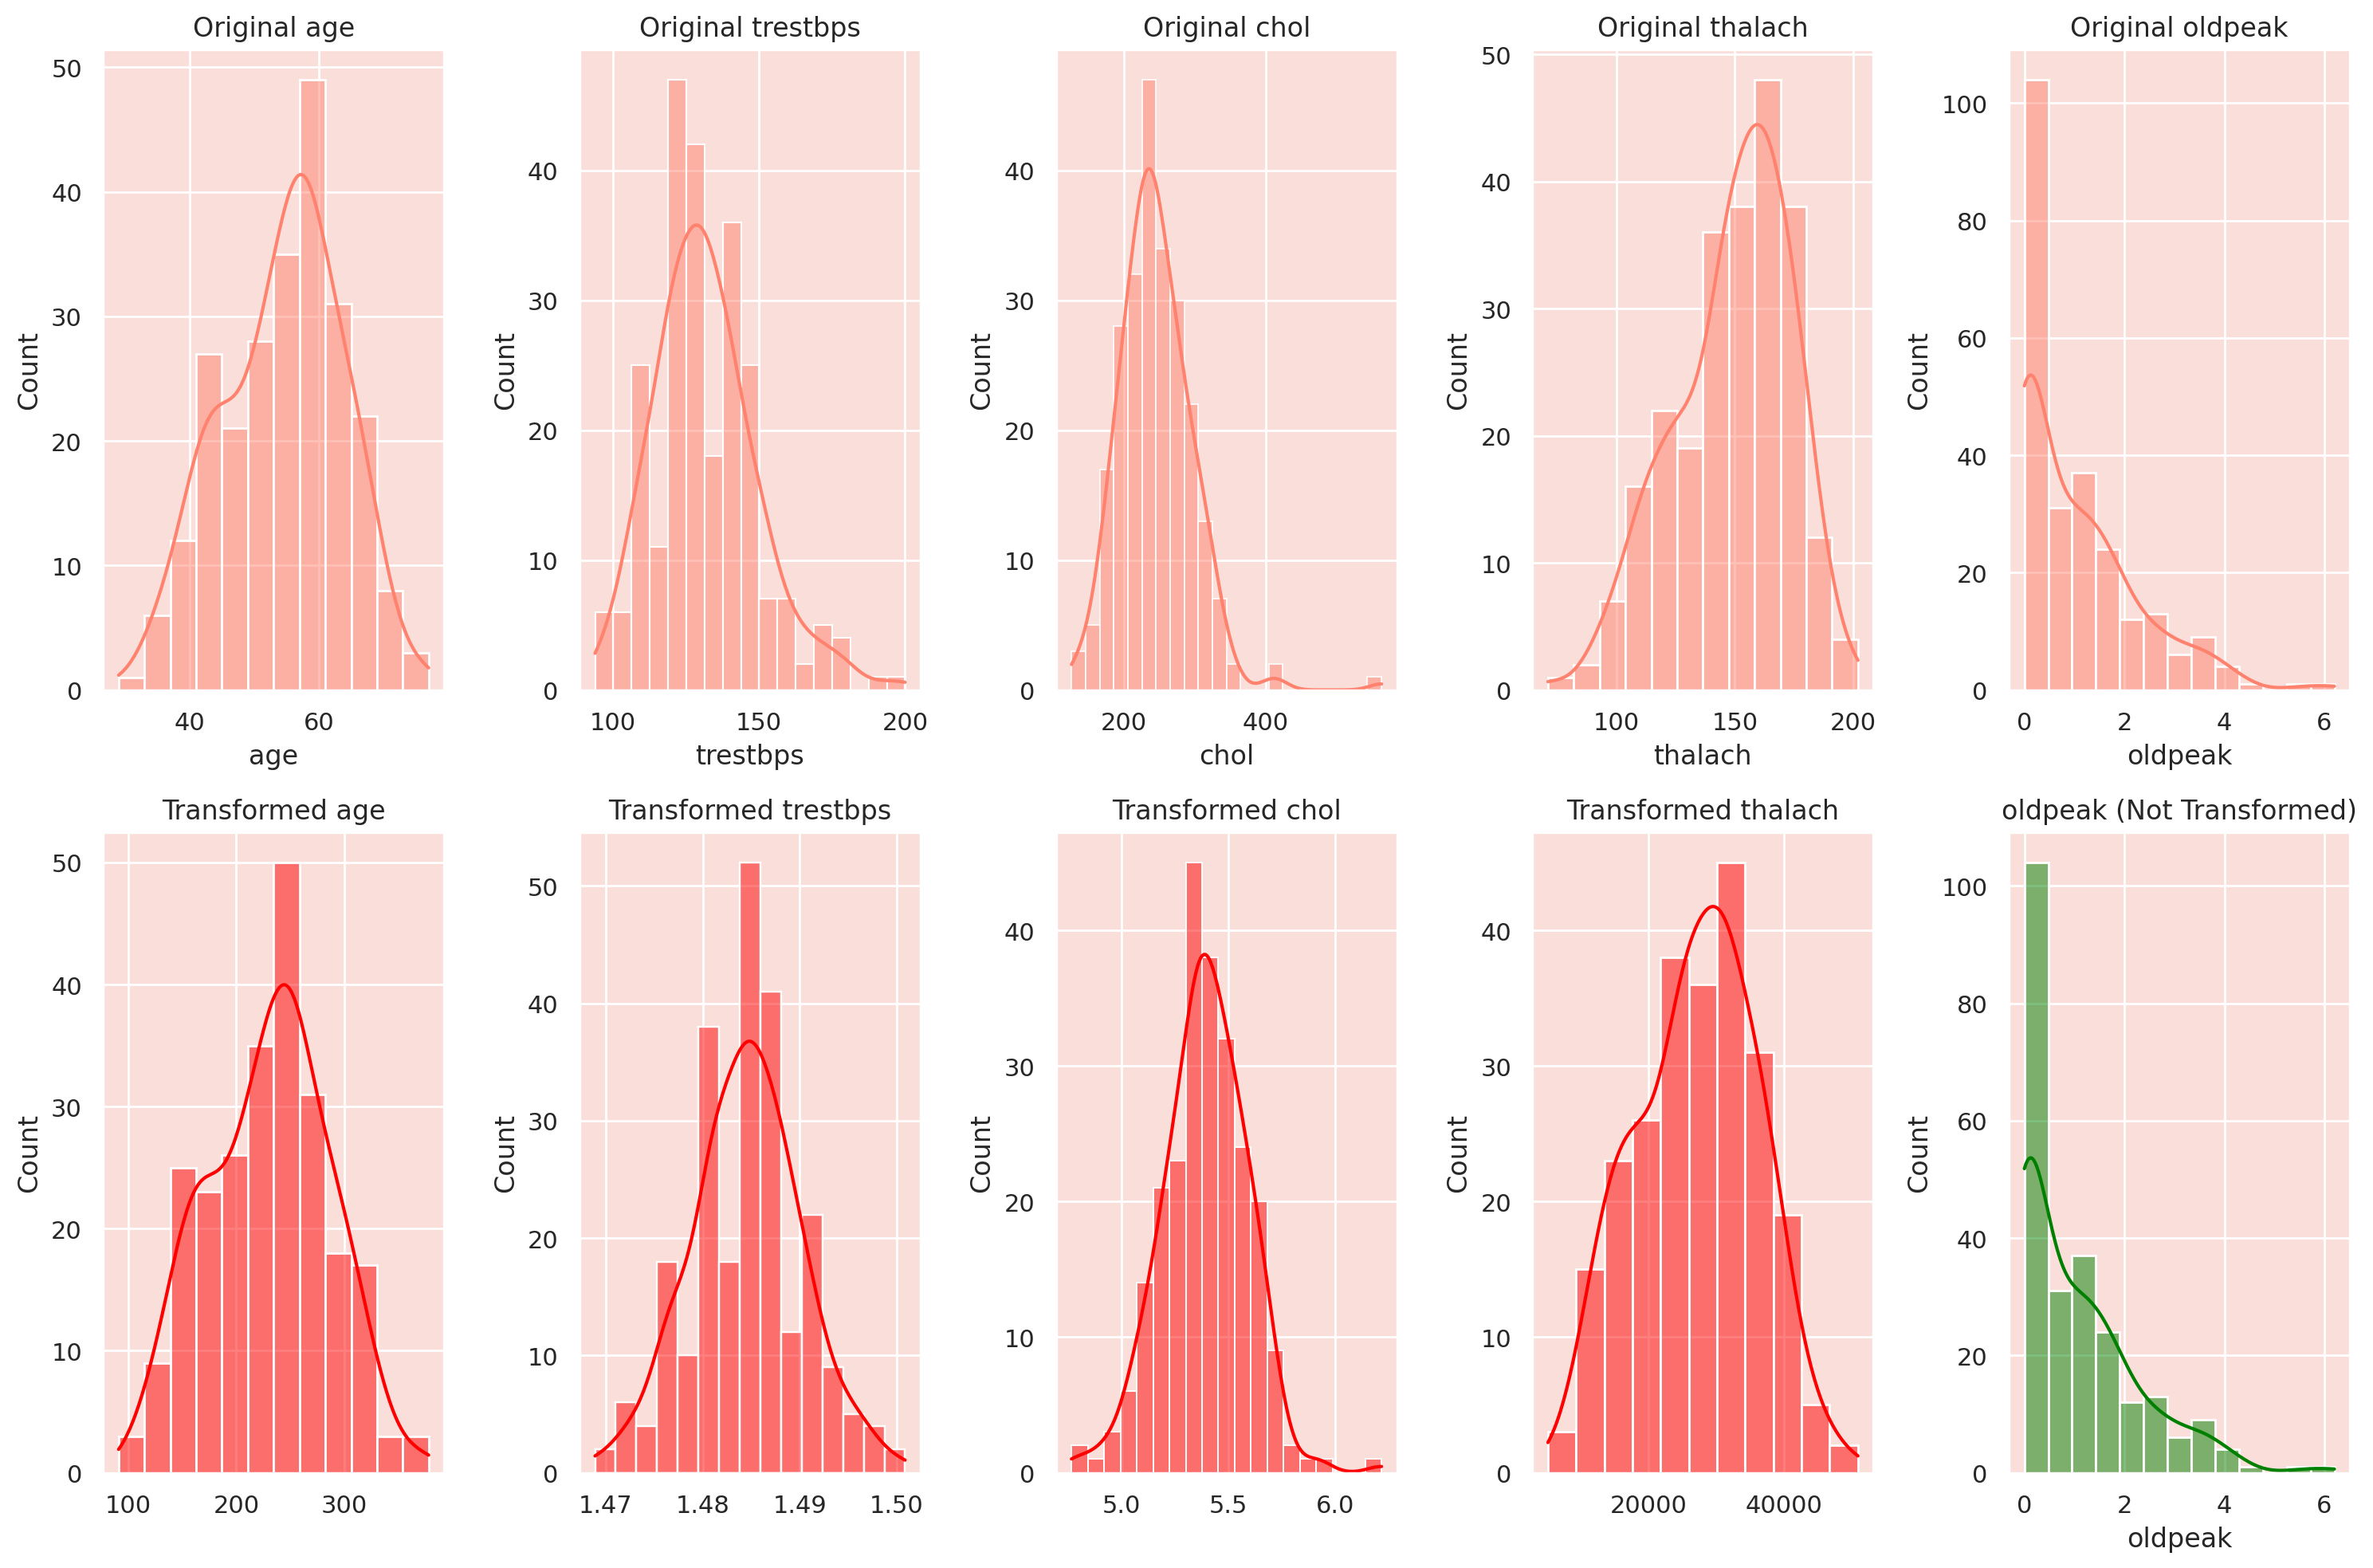

Test transformed data for age: Min: 150.97272006540953, Max: 150.97272006540953, Mean: 150.97272006540953
Test transformed data for trestbps: Min: 1.4831799488923738, Max: 1.4831799488923738, Mean: 1.4831799488923738
Test transformed data for chol: Min: 5.625448651162493, Max: 5.625448651162493, Mean: 5.625448651162493
Test transformed data for thalach: Min: 31871.00339396917, Max: 31871.00339396917, Mean: 31871.00339396917
+------------------+---+---+------------------+-----------------+---+-------+-----------------+-----+-------+-----+---+----+------+--------+-------------+
|               age|sex| cp|          trestbps|             chol|fbs|restecg|          thalach|exang|oldpeak|slope| ca|thal|target|cp_index|   cp_encoded|
+------------------+---+---+------------------+-----------------+---+-------+-----------------+-----+-------+-----+---+----+------+--------+-------------+
|150.97272006540953|  0|  1|1.4831799488923738|5.625448651162493|  0|      1|31871.00339396917|    0|    0.

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import numpy as np

# Start Spark session (if not already running)
spark = SparkSession.builder.appName("BoxCoxTransformation").getOrCreate()

# Assuming 'df_encoded' is your original DataFrame in PySpark
# For this example, I will use a random split to simulate X_train and X_test
# Split data into training and testing sets
train_data, test_data = df_encoded.randomSplit([0.8, 0.2], seed=0)

# Define continuous features (update with your actual continuous features)
continuous_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']  # Modify with your actual features

# Convert to Pandas for visualization
pandas_df_train = train_data.select(continuous_features).toPandas()

# Original Distributions
fig, ax = plt.subplots(2, 5, figsize=(15,10))
for i, col in enumerate(continuous_features):
    sns.histplot(pandas_df_train[col], kde=True, ax=ax[0,i], color='#ff826e').set_title(f'Original {col}')

# Apply Box-Cox Transformation
lambdas = {}  # Dictionary to store lambda values
transformed_data = train_data
for i, col in enumerate(continuous_features):
    min_val = pandas_df_train[col].min()
    if min_val > 0:  # Box-Cox requires strictly positive values
        # Apply Box-Cox transformation on the train set
        transformed_data_col, lambda_val = boxcox(pandas_df_train[col])
        lambdas[col] = lambda_val

        # Debugging: Print some of the transformed data
        print(f"Transformed data for {col}: Min: {np.min(transformed_data_col)}, Max: {np.max(transformed_data_col)}, Mean: {np.mean(transformed_data_col)}")

        # Update the DataFrame with transformed data
        transformed_data = transformed_data.withColumn(col, F.lit(lambda_val))  # Just a placeholder
        sns.histplot(transformed_data_col, kde=True, ax=ax[1,i], color='red').set_title(f'Transformed {col}')
    else:
        sns.histplot(pandas_df_train[col], kde=True, ax=ax[1,i], color='green').set_title(f'{col} (Not Transformed)')

fig.tight_layout()
plt.show()

# Apply Box-Cox Transformation to X_test
for col in continuous_features:
    if col in lambdas:
        # Apply the same lambda to the test data
        test_data_df = test_data.select(col).toPandas()

        # Apply Box-Cox transformation (extract only the transformed data)
        transformed_data_test = boxcox(test_data_df[col], lmbda=lambdas[col])[0]

        # Debugging: Print some of the transformed test data
        print(f"Test transformed data for {col}: Min: {np.min(transformed_data_test)}, Max: {np.max(transformed_data_test)}, Mean: {np.mean(transformed_data_test)}")

        # Update test data with the transformed values
        test_data = test_data.withColumn(col, F.lit(transformed_data_test))  # Update with scalar value

test_data.show()  # Show the transformed test data


In [ ]:
# Get the first 5 rows as a list of Row objects
rows = df.take(5)

# Display the rows
for row in rows:
    print(row)


Row(age=63, sex='1', cp='3', trestbps=145, chol=233, fbs='1', restecg='0', thalach=150, exang='0', oldpeak=2.3, slope='0', ca='0', thal='1', target='1')
Row(age=37, sex='1', cp='2', trestbps=130, chol=250, fbs='0', restecg='1', thalach=187, exang='0', oldpeak=3.5, slope='0', ca='0', thal='2', target='1')
Row(age=41, sex='0', cp='1', trestbps=130, chol=204, fbs='0', restecg='0', thalach=172, exang='0', oldpeak=1.4, slope='2', ca='0', thal='2', target='1')
Row(age=56, sex='1', cp='1', trestbps=120, chol=236, fbs='0', restecg='1', thalach=178, exang='0', oldpeak=0.8, slope='2', ca='0', thal='2', target='1')
Row(age=57, sex='0', cp='0', trestbps=120, chol=354, fbs='0', restecg='1', thalach=163, exang='1', oldpeak=0.6, slope='2', ca='0', thal='2', target='1')


In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer

# Combine features into a single vector
feature_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']  # Replace with your continuous features
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_transformed = assembler.transform(df_encoded)

# Index the target column
target_indexer = StringIndexer(inputCol="target", outputCol="target_index")
df_transformed = target_indexer.fit(df_transformed).transform(df_transformed)

# Split the data into train and test sets
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

# Define the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="target_index", metricName="areaUnderROC")

# 1. Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="target_index")
lr_param_grid = ParamGridBuilder().addGrid(lr.regParam, [0.01, 0.1, 1]).build()

# 2. Support Vector Machine (SVM)
svm = LinearSVC(featuresCol="features", labelCol="target_index")
svm_param_grid = ParamGridBuilder().addGrid(svm.regParam, [0.01, 0.1, 1]).build()

# 3. Random Forest Classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="target_index")
rf_param_grid = ParamGridBuilder().addGrid(rf.numTrees, [50, 100]) \
                                  .addGrid(rf.maxDepth, [5, 10]).build()

# Combine models with their parameter grids
models = {
    "Logistic Regression": (lr, lr_param_grid),
    "SVM": (svm, svm_param_grid),
    "Random Forest": (rf, rf_param_grid)
}

# Perform grid search with cross-validation
best_models = {}
for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}...")

    # Cross-validator setup
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=5)  # 5-fold cross-validation

    # Fit model and retrieve the best model
    cv_model = crossval.fit(train_data)
    best_models[model_name] = cv_model.bestModel
    print(f"Best {model_name} model trained.")

# Evaluate the models on the test set
for model_name, best_model in best_models.items():
    print(f"Evaluating {model_name}...")
    predictions = best_model.transform(test_data)
    auc = evaluator.evaluate(predictions)
    print(f"{model_name} AUC: {auc}")


Training Logistic Regression...
Best Logistic Regression model trained.
Training SVM...
Best SVM model trained.
Training Random Forest...
Best Random Forest model trained.
Evaluating Logistic Regression...
Logistic Regression AUC: 0.8139097744360902
Evaluating SVM...
SVM AUC: 0.8120300751879701
Evaluating Random Forest...
Random Forest AUC: 0.7988721804511282


Evaluating Logistic Regression...
--- Logistic Regression ---
Accuracy: 0.8085
Weighted Precision: 0.8301
Weighted Recall: 0.8085
F1-Score: 0.7975
ROC-AUC: 0.8139



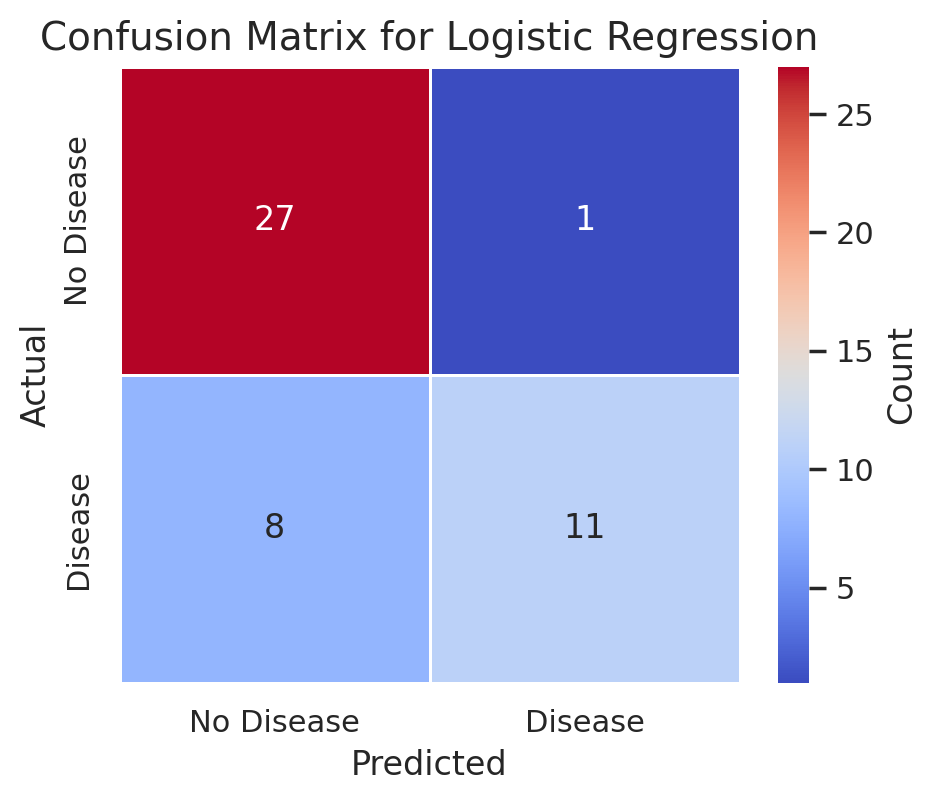

Evaluating SVM...
--- SVM ---
Accuracy: 0.8298
Weighted Precision: 0.8676
Weighted Recall: 0.8298
F1-Score: 0.8177
ROC-AUC: 0.8120



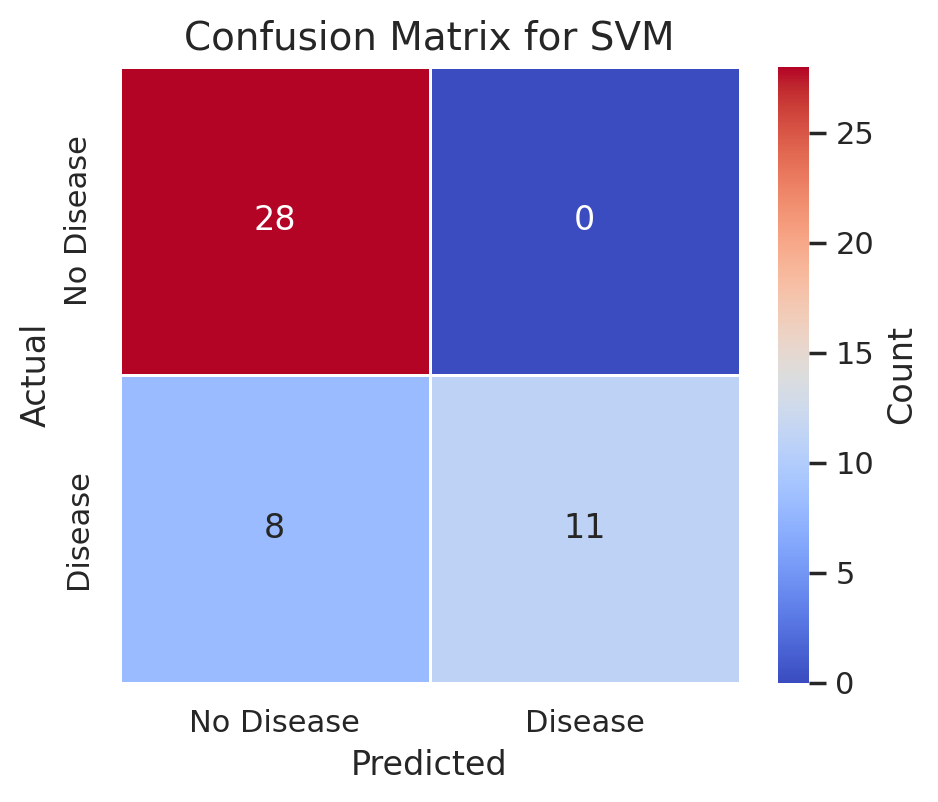

Evaluating Random Forest...
--- Random Forest ---
Accuracy: 0.7872
Weighted Precision: 0.7888
Weighted Recall: 0.7872
F1-Score: 0.7818
ROC-AUC: 0.7989



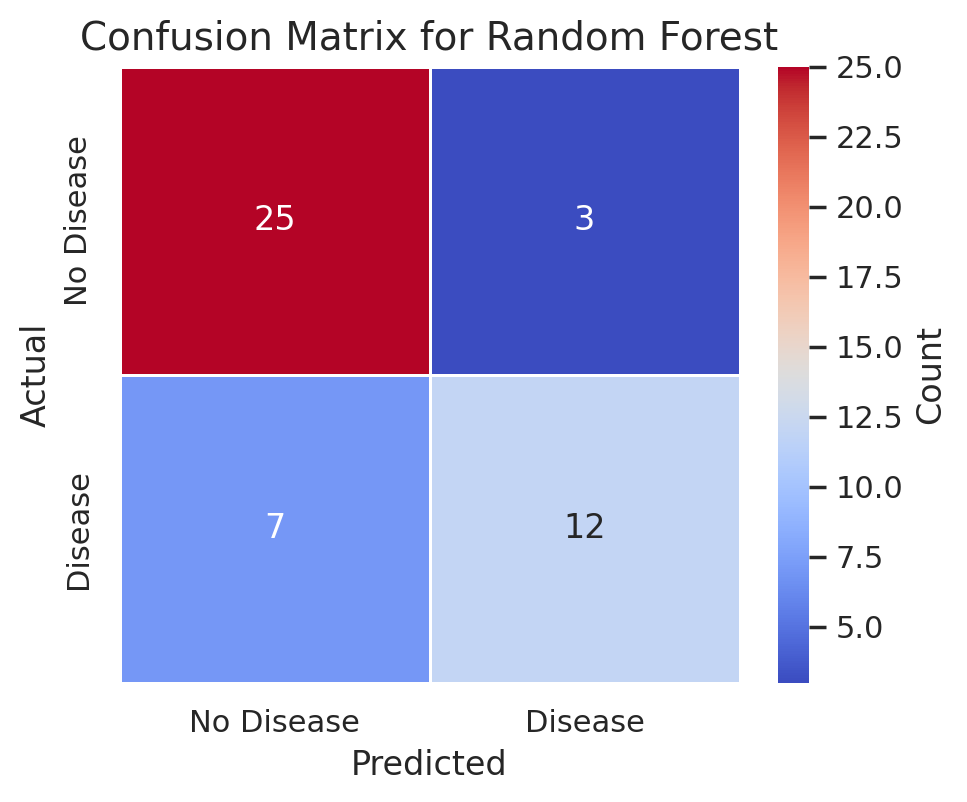

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="target_index", predictionCol="prediction", metricName="accuracy")
weighted_precision_evaluator = MulticlassClassificationEvaluator(labelCol="target_index", predictionCol="prediction", metricName="weightedPrecision")
weighted_recall_evaluator = MulticlassClassificationEvaluator(labelCol="target_index", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="target_index", predictionCol="prediction", metricName="f1")

# Assuming `best_models` is a dictionary containing the trained models and `test_data` is your test dataset
for model_name, best_model in best_models.items():
    print(f"Evaluating {model_name}...")
    predictions = best_model.transform(test_data)

    # Calculate metrics
    accuracy = accuracy_evaluator.evaluate(predictions)
    weighted_precision = weighted_precision_evaluator.evaluate(predictions)
    weighted_recall = weighted_recall_evaluator.evaluate(predictions)
    f1_score = f1_evaluator.evaluate(predictions)

    print(f"--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall: {weighted_recall:.4f}")
    print(f"F1-Score: {f1_score:.4f}")

    # Calculate AUC-ROC for binary classification
    binary_evaluator = BinaryClassificationEvaluator(labelCol="target_index", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    auc = binary_evaluator.evaluate(predictions)
    print(f"ROC-AUC: {auc:.4f}\n")

    # Confusion Matrix
    confusion_matrix = predictions.groupBy("target_index", "prediction").count().orderBy("target_index", "prediction")
    confusion_matrix_df = confusion_matrix.toPandas().pivot(index='target_index', columns='prediction', values='count').fillna(0).astype(int)

    # Visualize Confusion Matrix with improved aesthetics
    plt.figure(figsize=(5, 4))  # Smaller size
    sns.heatmap(confusion_matrix_df, annot=True, fmt="d", cmap="coolwarm", xticklabels=['No Disease', 'Disease'], yticklabels=['No Disease', 'Disease'],
                cbar_kws={'label': 'Count'}, annot_kws={"size": 12}, linewidths=0.5)
    plt.title(f'Confusion Matrix for {model_name}', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.show()


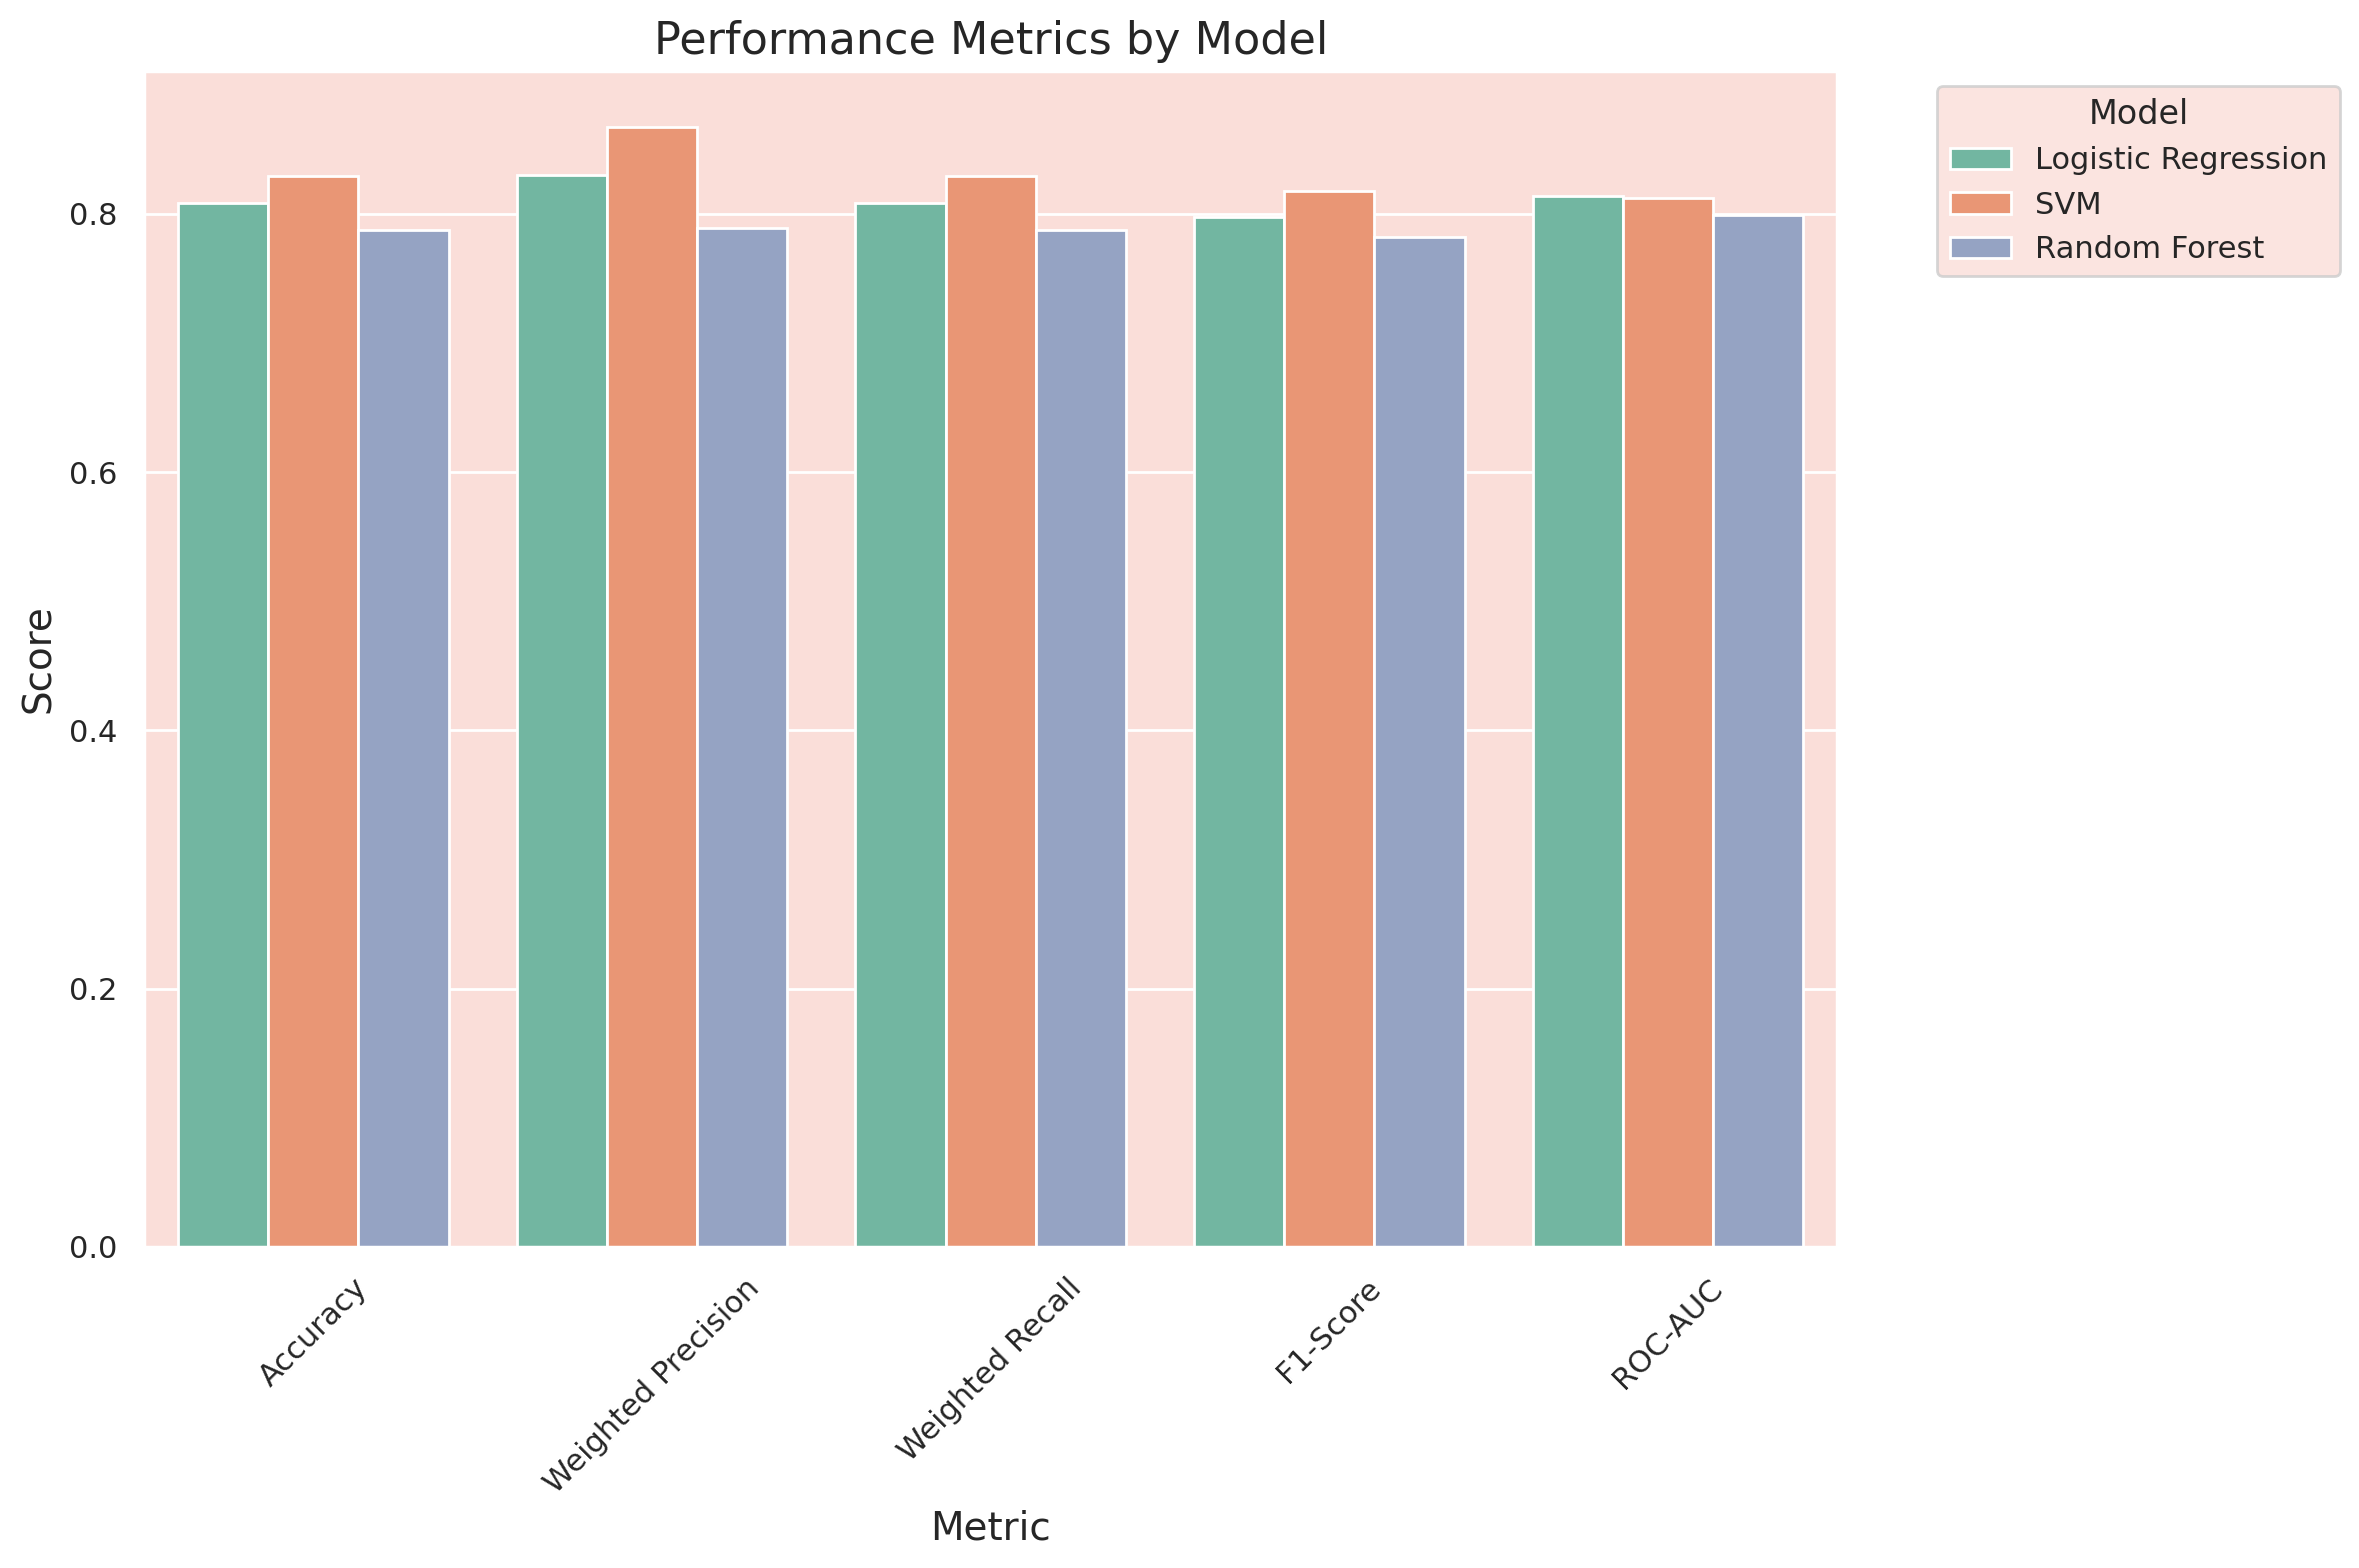

Best performing model: SVM


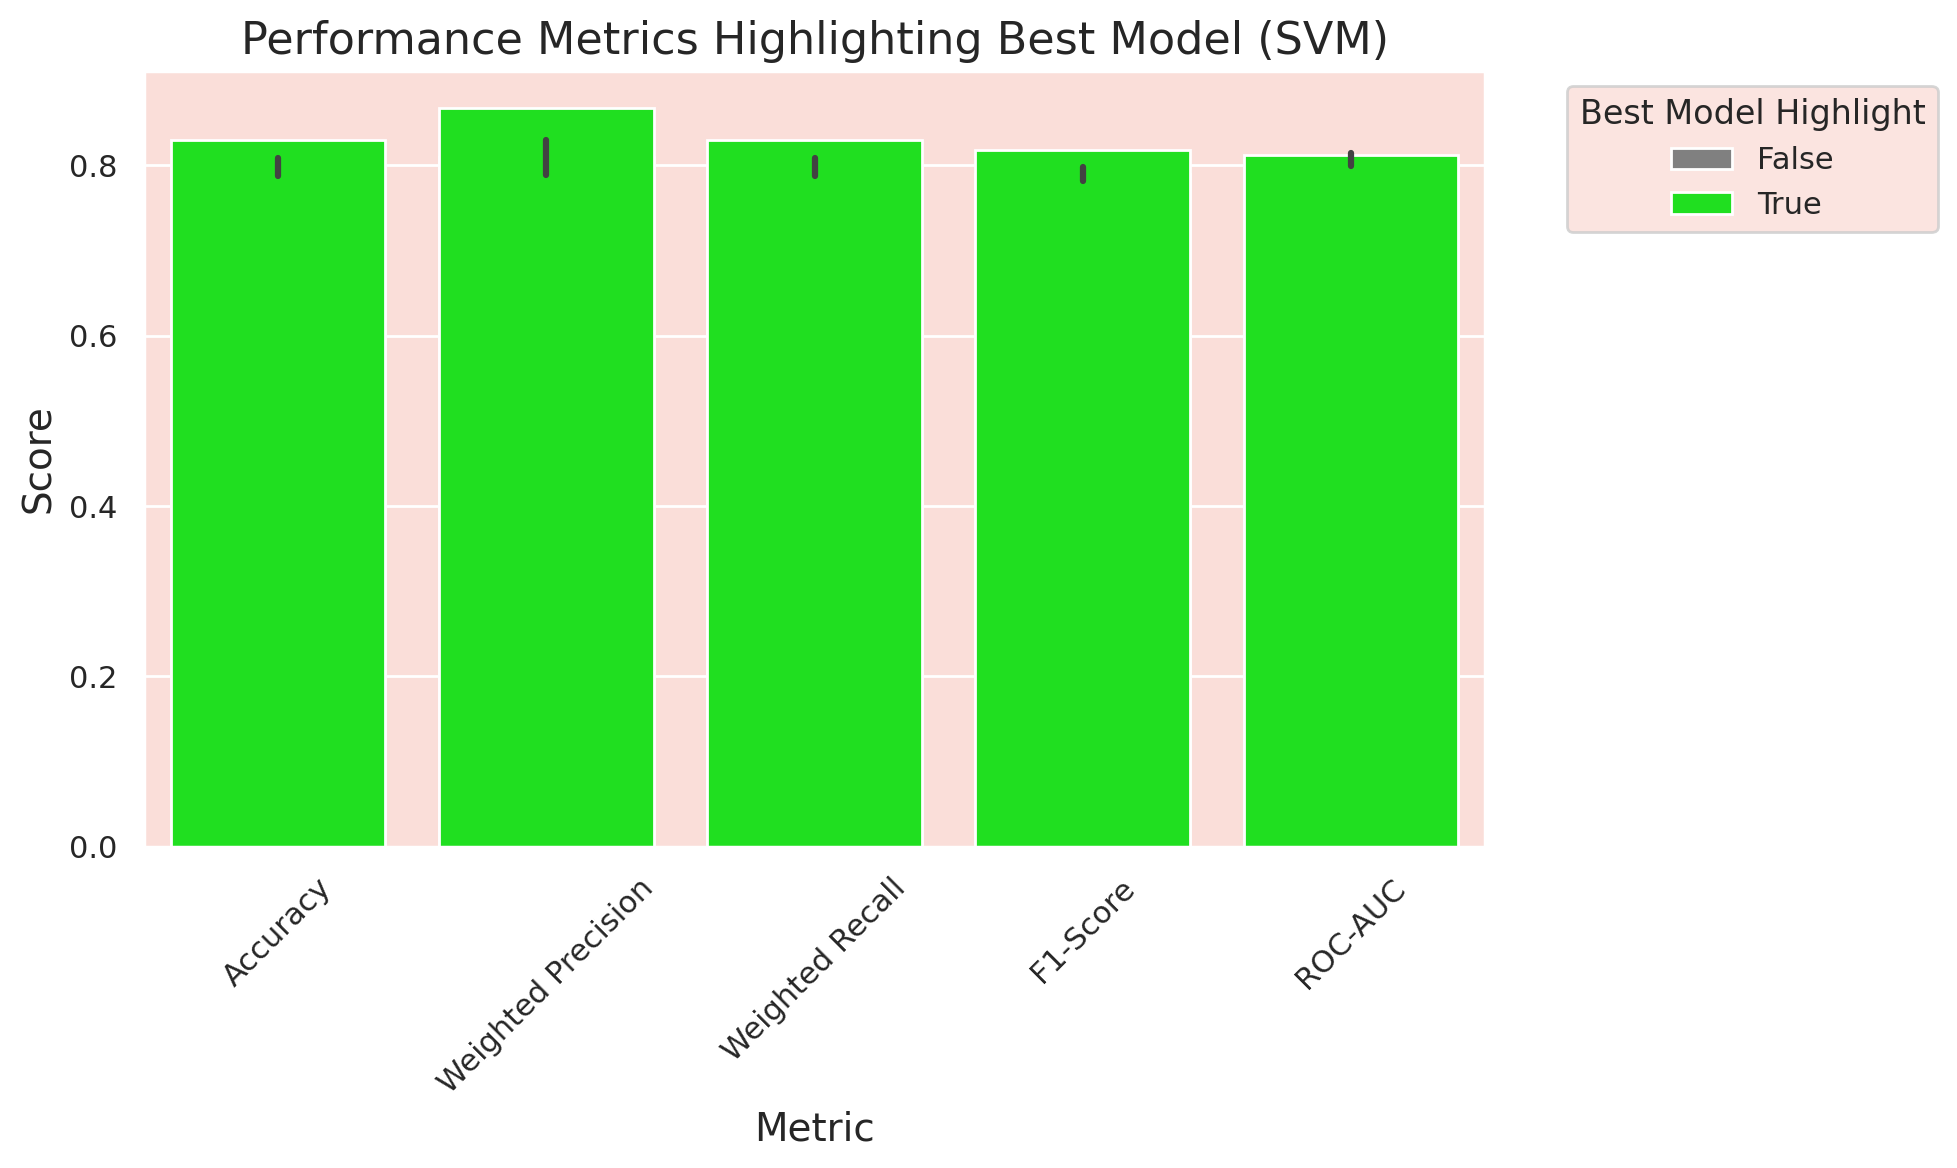

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="target_index", predictionCol="prediction", metricName="accuracy")
weighted_precision_evaluator = MulticlassClassificationEvaluator(labelCol="target_index", predictionCol="prediction", metricName="weightedPrecision")
weighted_recall_evaluator = MulticlassClassificationEvaluator(labelCol="target_index", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="target_index", predictionCol="prediction", metricName="f1")

# Assuming `best_models` is a dictionary containing the trained models and `test_data` is your test dataset
metrics_summary = []

for model_name, best_model in best_models.items():
    predictions = best_model.transform(test_data)

    # Calculate metrics
    accuracy = accuracy_evaluator.evaluate(predictions)
    weighted_precision = weighted_precision_evaluator.evaluate(predictions)
    weighted_recall = weighted_recall_evaluator.evaluate(predictions)
    f1_score = f1_evaluator.evaluate(predictions)

    # Calculate AUC for binary classification
    binary_evaluator = BinaryClassificationEvaluator(labelCol="target_index", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
    auc = binary_evaluator.evaluate(predictions)

    metrics_summary.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Weighted Precision": weighted_precision,
        "Weighted Recall": weighted_recall,
        "F1-Score": f1_score,
        "ROC-AUC": auc
    })

# Convert metrics summary to a Pandas DataFrame for analysis
metrics_df = pd.DataFrame(metrics_summary)

# Visualize Metrics
plt.figure(figsize=(12, 8))
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(data=metrics_melted, x="Metric", y="Score", hue="Model", palette="Set2")
plt.title("Performance Metrics by Model", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Identify the best model based on F1-Score
best_model_name = metrics_df.loc[metrics_df['F1-Score'].idxmax(), 'Model']
print(f"Best performing model: {best_model_name}")

# Highlight the best model in the visualization
highlight_df = metrics_df.copy()
highlight_df['Best Model'] = highlight_df['Model'] == best_model_name

plt.figure(figsize=(10, 6))
sns.barplot(data=highlight_df.melt(id_vars=["Model", "Best Model"], var_name="Metric", value_name="Score"),
            x="Metric", y="Score", hue="Best Model", dodge=False, palette={True: "lime", False: "gray"})
plt.title(f"Performance Metrics Highlighting Best Model ({best_model_name})", fontsize=16)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Metric", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Best Model Highlight", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
import pandas as pd

# Assuming df is a PySpark DataFrame
# Convert PySpark DataFrame to Pandas DataFrame for use with scikit-learn
df_pandas = df.toPandas()

# Step 1: Separate features and target
X = df_pandas.drop('target', axis=1)  # 'target' is the label column
y = df_pandas['target']  # Target variable

# Step 2: Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create an SVM pipeline with scaling
svm_pipeline = make_pipeline(StandardScaler(), SVC())

# Step 4: Define parameter grid for GridSearchCV
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto', 0.01, 0.1, 1],
    'svc__degree': [2, 3, 4],
    'svc__class_weight': [None, 'balanced'],
}

# Step 5: Use StratifiedKFold for cross-validation (preserves class balance)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# Step 6: GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=svm_pipeline, param_grid=param_grid, cv=cv, scoring='accuracy', verbose=1, n_jobs=-1)

# Step 7: Fit GridSearchCV to training data
grid_search.fit(X_train, y_train)

# Step 8: Best parameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Step 9: Evaluate on the test set
test_accuracy = grid_search.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
Best Hyperparameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best Cross-Validation Accuracy: 0.8180272108843537
Test Accuracy: 0.8689


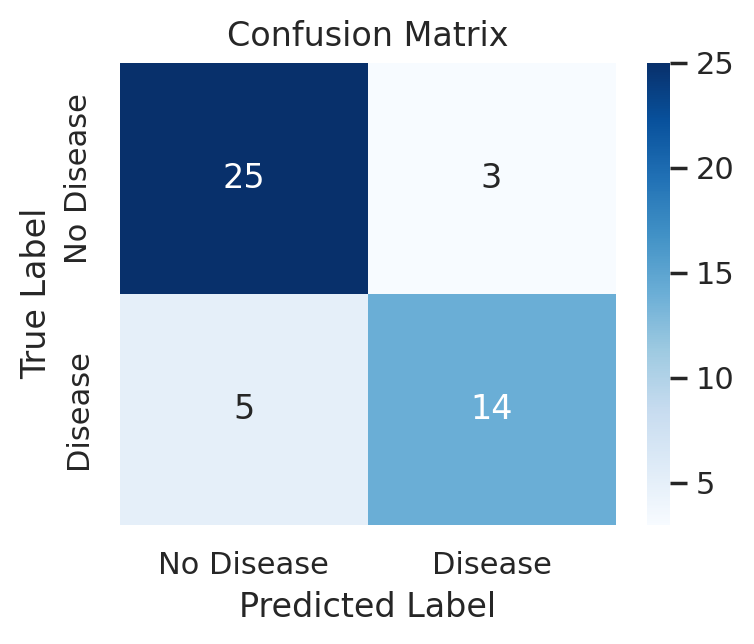

ROC AUC Score: 0.89


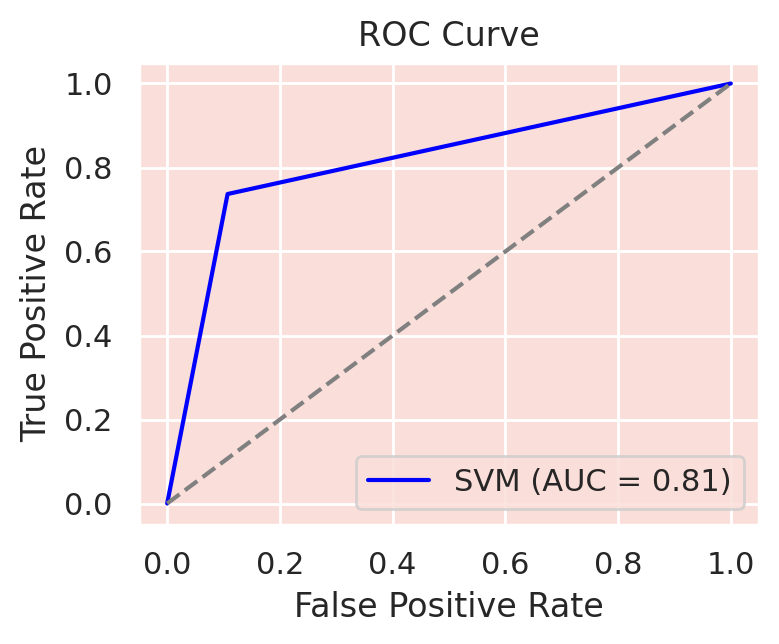

In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import pandas as pd

# Assuming 'df' is the preprocessed DataFrame with the target column as a string.

# Step 1: Convert Target Column to Numeric
if "target_numeric" not in df.columns:
    target_indexer = StringIndexer(inputCol="target", outputCol="target_numeric").fit(df)
    df = target_indexer.transform(df)

# Step 2: Identify Categorical Columns
categorical_columns = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
numeric_columns = [col for col in df.columns if col not in categorical_columns + ["target", "target_numeric"]]

# Step 3: Encode Categorical Columns
for col in categorical_columns:
    output_col = col + "_index"
    if output_col not in df.columns:
        indexer = StringIndexer(inputCol=col, outputCol=output_col).fit(df)
        df = indexer.transform(df)

encoded_columns = [col + "_index" for col in categorical_columns]

# Step 4: Assemble Features into a Vector Column
if "features" not in df.columns:
    feature_columns = numeric_columns + encoded_columns
    assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    df = assembler.transform(df)

# Step 5: Split the Data into Training and Testing Sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

# Step 6: Train the SVM Model
svm = LinearSVC(labelCol="target_numeric", featuresCol="features", maxIter=100)
svm_model = svm.fit(train_data)

# Step 7: Predict on Test Data
svm_predictions = svm_model.transform(test_data)

# Step 8: Evaluate the Model
# Convert predictions to pandas for confusion matrix and ROC curve
y_true = svm_predictions.select('target_numeric').toPandas()
y_pred = svm_predictions.select('prediction').toPandas()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="target_numeric", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(svm_predictions)
print(f"ROC AUC Score: {roc_auc:.2f}")

# Extract true positive rate (TPR) and false positive rate (FPR)
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc_score = auc(fpr, tpr)

plt.figure(figsize=(4, 3))
plt.plot(fpr, tpr, color='blue', label=f'SVM (AUC = {roc_auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


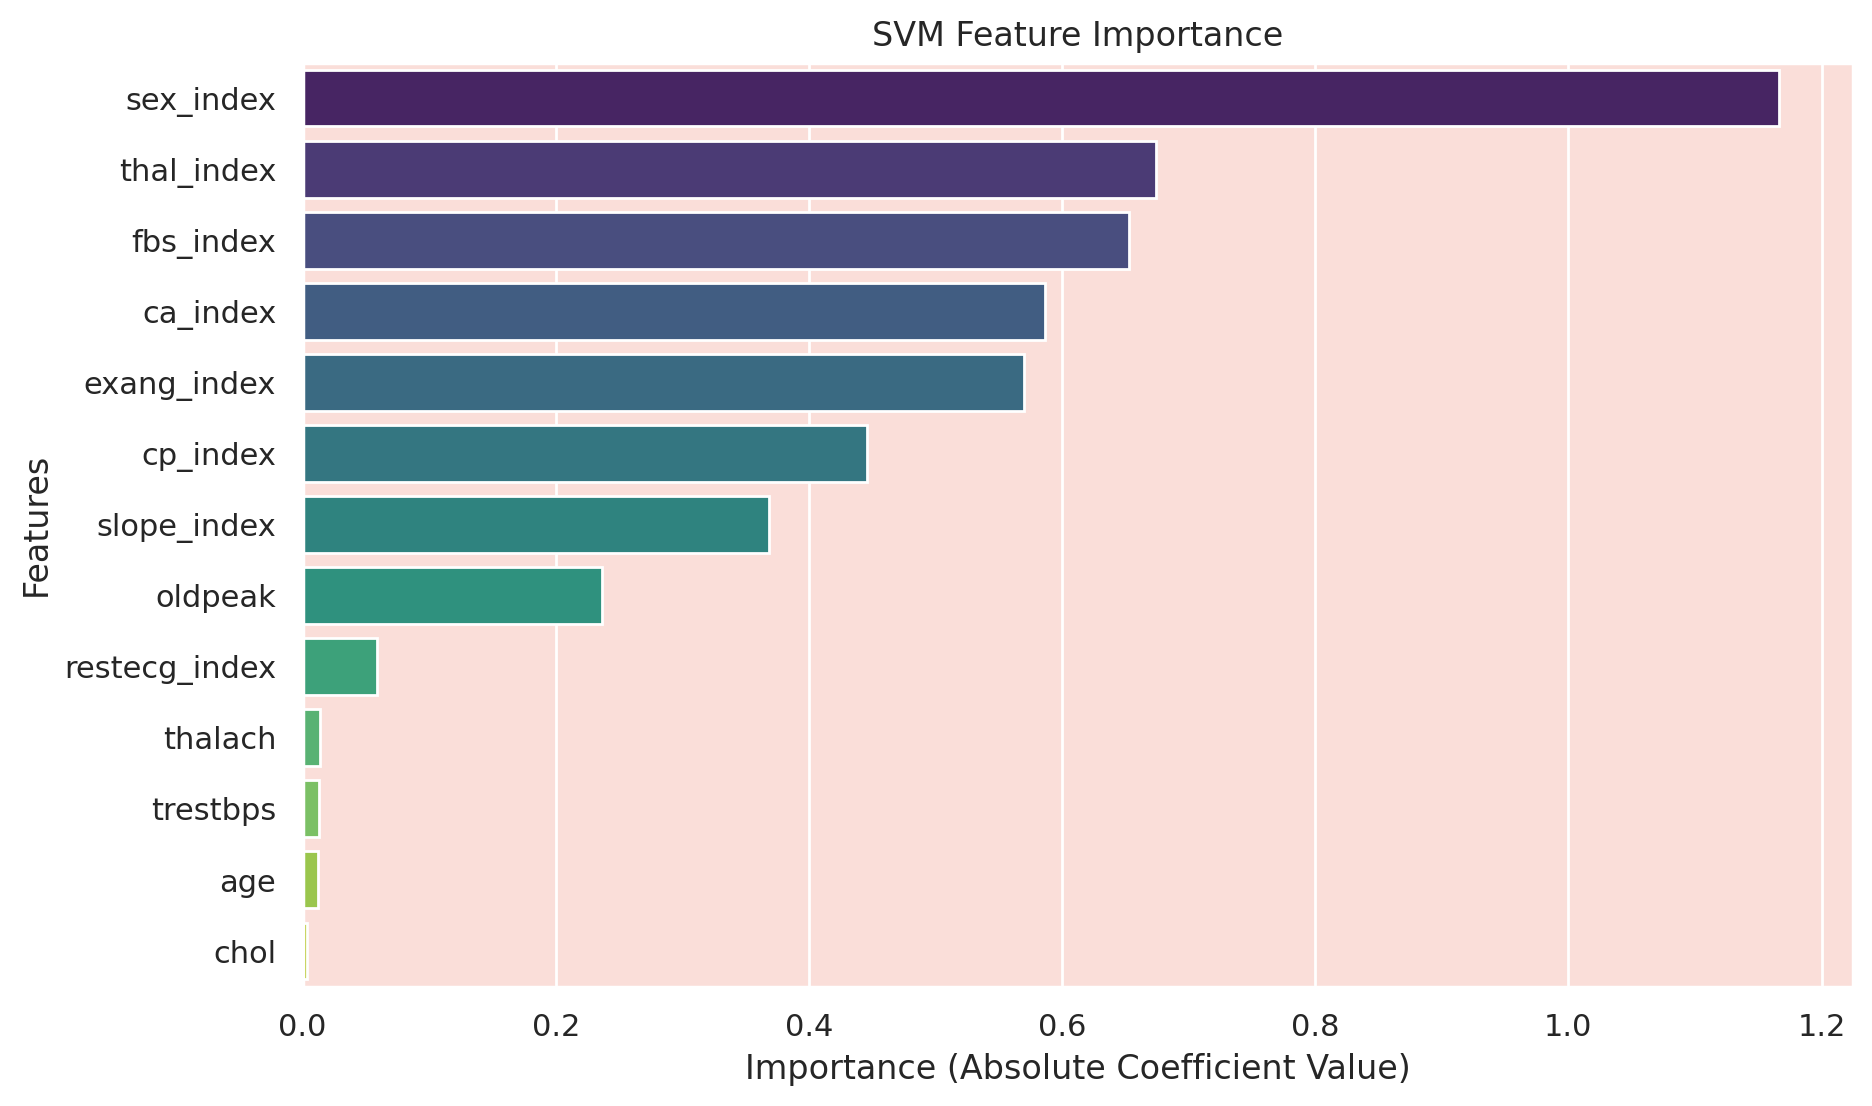

In [ ]:
  # Step 9: Calculate Feature Importance for SVM
# Extract feature coefficients from the trained SVM model
coefficients = svm_model.coefficients.toArray()

# Create a DataFrame for feature importance visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': abs(coefficients)  # Use absolute values of coefficients
}).sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('SVM Feature Importance')
plt.xlabel('Importance (Absolute Coefficient Value)')
plt.ylabel('Features')
plt.show()
